##Country-wise analysis of exports and imports##
based on 4 csv files (NOT metal-wise)
Date: 5/1/25


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import folium


# Load data
country_codes = pd.read_csv('country_codes_V202501.csv')
product_codes = pd.read_csv('product_codes_HS12_V202501.csv')

import glob

# Define the file path pattern (update path as needed)
file_pattern = "BACI_HS12_Y*_V202501.csv"

# Get a list of all matching files
file_list = glob.glob(file_pattern)

# Read and merge all files
df_list = [pd.read_csv(file) for file in file_list]
df = pd.concat(df_list, ignore_index=True)

# Rename columns for clarity
df.columns = ['Year', 'Exporter', 'Importer', 'Product', 'Value', 'Quantity']

# Merge country names
df = df.merge(country_codes, left_on='Exporter', right_on='country_code', how='left')
df.rename(columns={'country_name': 'Exporter_Name'}, inplace=True)
df = df.merge(country_codes, left_on='Importer', right_on='country_code', how='left')
df.rename(columns={'country_name': 'Importer_Name'}, inplace=True)

product_codes['Product'] = product_codes['code']
product_codes.drop(['code'], axis=1, inplace=True)
product_codes

df = df.merge(product_codes, on="Product", how="left")


In [ ]:
ore_extraction_hs = [260300, 260600, 260900, 260400, 261590, 261510, 260500, 261690, 261610, 253090]
refining_hs = [740311, 740819, 760110, 760521, 800110, 750210, 810330, 283691, 810520, 710812, 710691, 280530]
manufacturing_hs = [854231, 854239, 853400, 853222, 853321, 850440, 850760, 853690, 847170, 841459, 854140]
mining_hs = [253090, 260111, 260112, 260200, 260300, 260400, 260500, 260600, 260700, 260800, 260900, 261000, 261100, 261510, 261590, 261610, 261690, 261710]

df_ore_extraction = df[df['Product'].isin(ore_extraction_hs)]
df_refining = df[df['Product'].isin(refining_hs)]
df_manufacturing = df[df['Product'].isin(manufacturing_hs)]
df_mining = df[df['Product'].isin(mining_hs)]


# dfs = [df_ore_extraction, df_refining, df_manufacturing, df_mining] 

dfs = [
    ("Ore Extraction", df_ore_extraction),
    ("Refining", df_refining),
    ("Manufacturing", df_manufacturing),
    ("Mining", df_mining)
]


for name, df_category in dfs:
    filename = f"{name.replace(' ', '_')}.csv"
    df_category.to_csv(filename, index=False)
    print(f"Saved: {filename}")

BY COUNTRY



==== Generating export chart for Ore Extraction ====


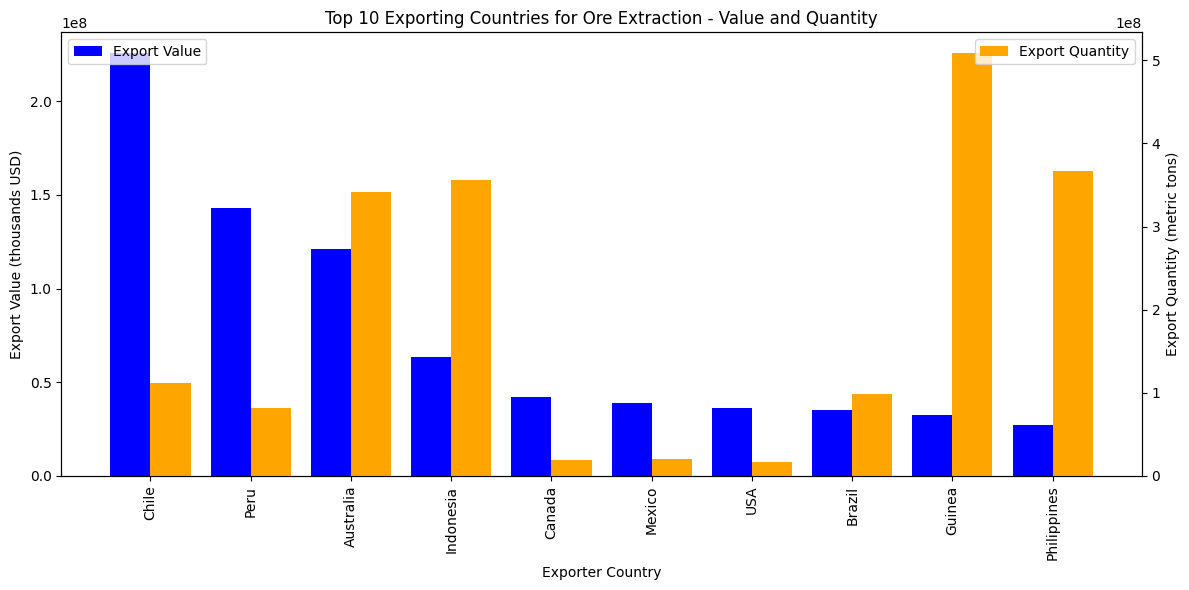


==== Generating export chart for Refining ====


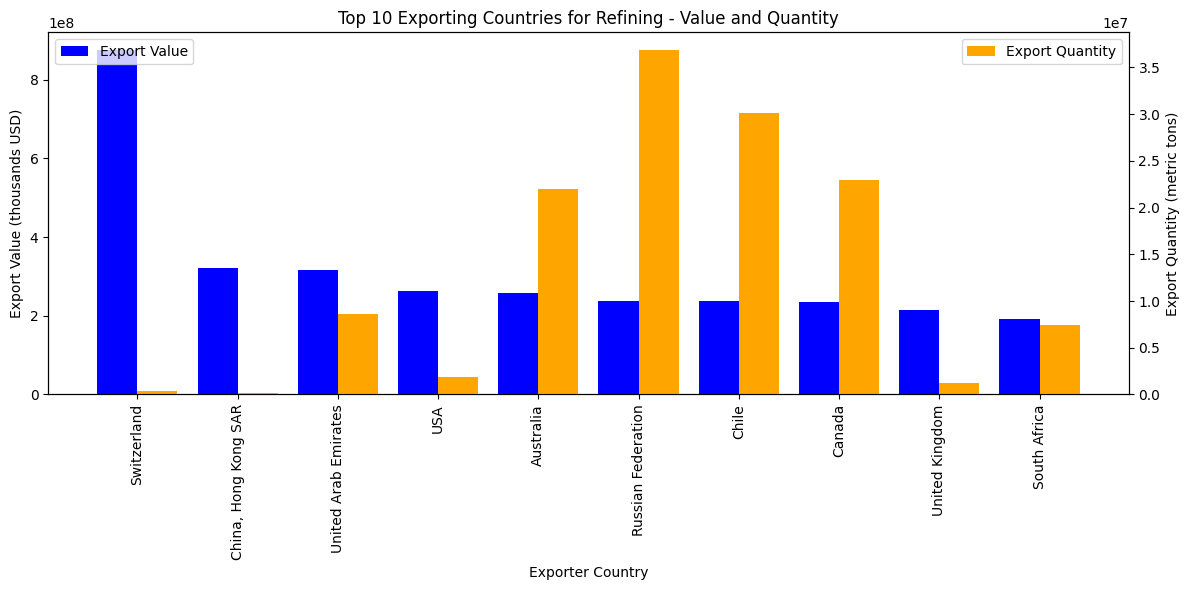


==== Generating export chart for Manufacturing ====


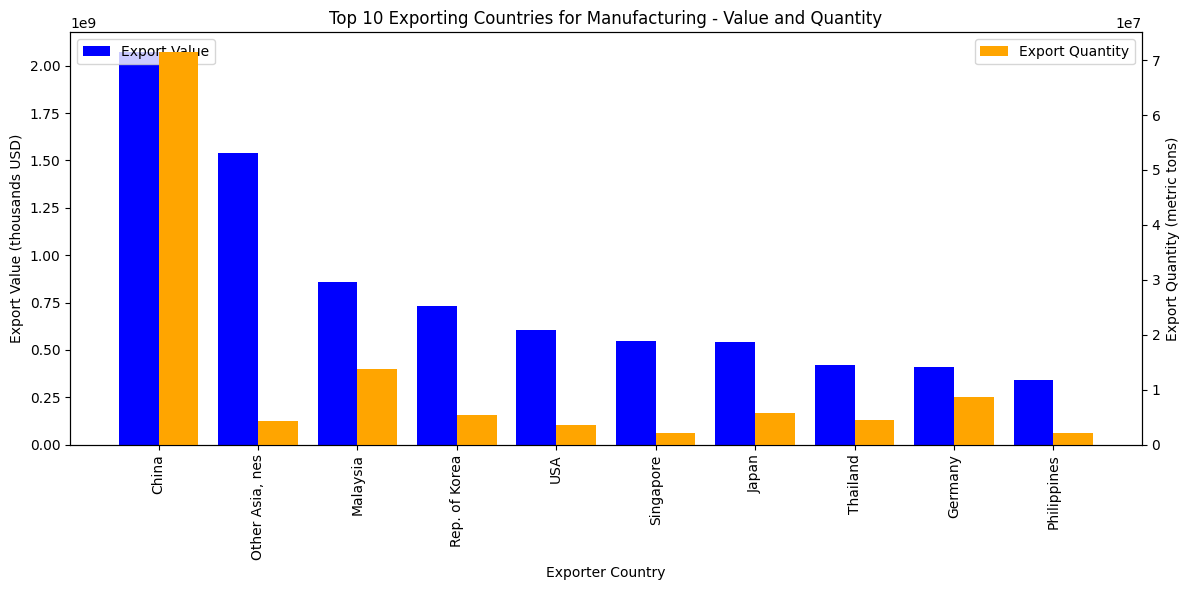


==== Generating export chart for Mining ====


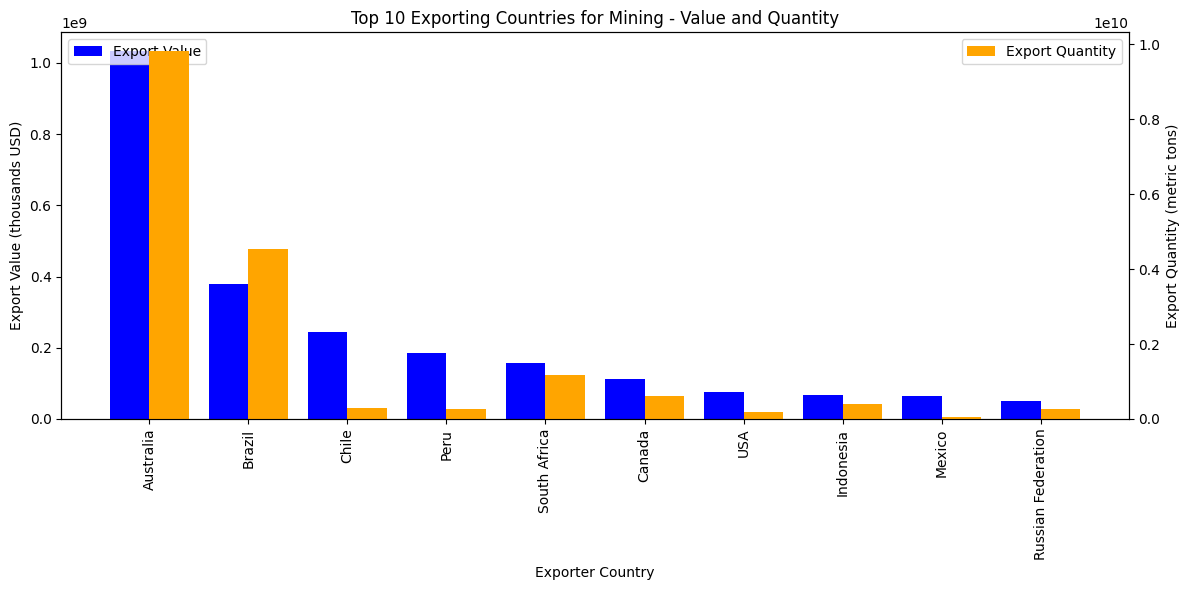

In [38]:
for name, df in dfs:
    print(f"\n==== Generating export chart for {name} ====")

    df_exports = df.groupby('Exporter_Name').agg({'Value': 'sum', 'Quantity': 'sum'}).reset_index()
    top_exporters = df_exports.nlargest(10, 'Value')

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    width = 0.4
    x = range(len(top_exporters))

    ax1.bar([p - width/2 for p in x], top_exporters['Value'], width=width, color='blue', label='Export Value')
    ax2.bar([p + width/2 for p in x], top_exporters['Quantity'], width=width, color='orange', label='Export Quantity')

    ax1.set_xticks(x)
    ax1.set_xticklabels(top_exporters['Exporter_Name'], rotation=90)
    ax1.set_ylabel("Export Value (thousands USD)")
    ax2.set_ylabel("Export Quantity (metric tons)")
    ax1.set_xlabel("Exporter Country")
    plt.title(f"Top 10 Exporting Countries for {name} - Value and Quantity")

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()



==== Generating import chart for Ore Extraction ====


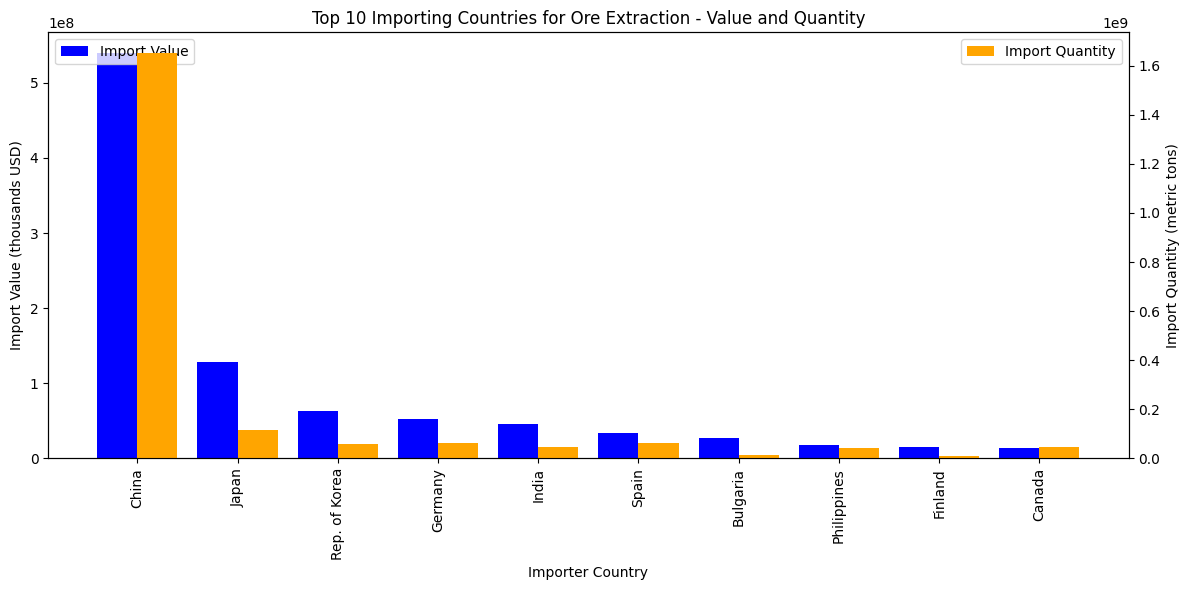


==== Generating import chart for Refining ====


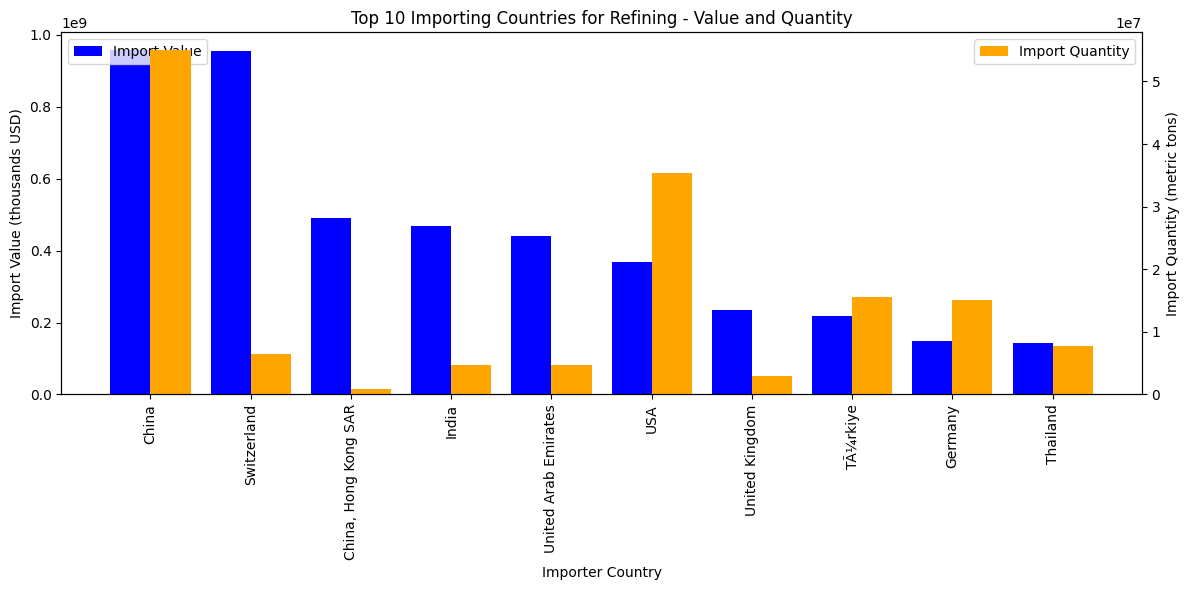


==== Generating import chart for Manufacturing ====


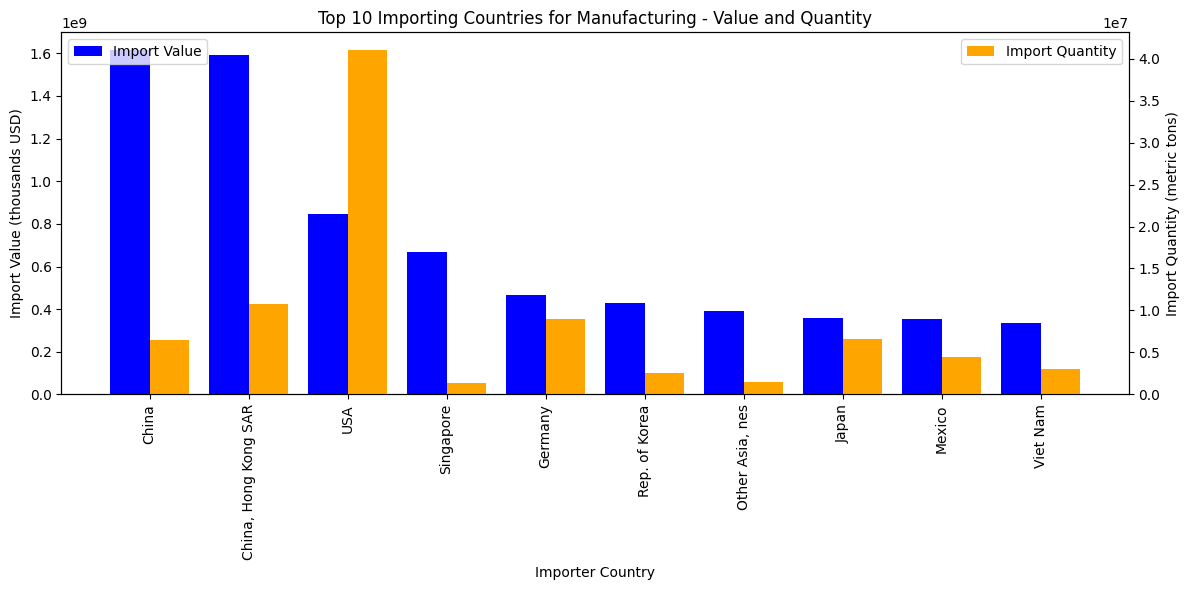


==== Generating import chart for Mining ====


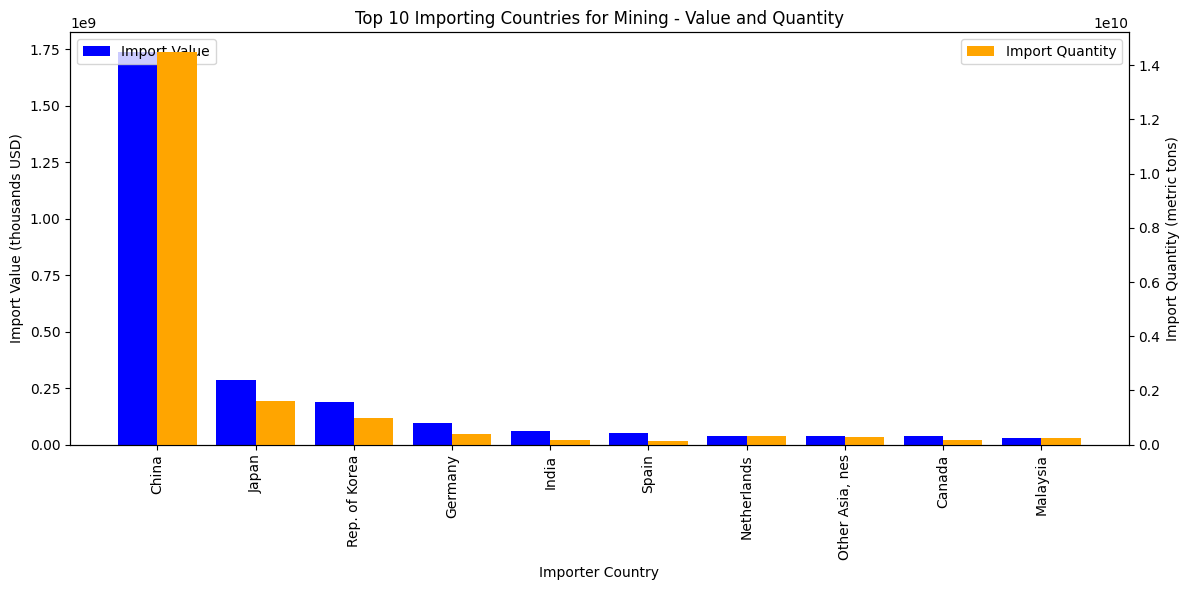

In [39]:
for name, df in dfs:
    print(f"\n==== Generating import chart for {name} ====")

    df_imports = df.groupby('Importer_Name').agg({'Value': 'sum', 'Quantity': 'sum'}).reset_index()
    top_importers = df_imports.nlargest(10, 'Value')

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    width = 0.4
    x = range(len(top_importers))

    ax1.bar([p - width/2 for p in x], top_importers['Value'], width=width, color='blue', label='Import Value')
    ax2.bar([p + width/2 for p in x], top_importers['Quantity'], width=width, color='orange', label='Import Quantity')

    ax1.set_xticks(x)
    ax1.set_xticklabels(top_importers['Importer_Name'], rotation=90)
    ax1.set_ylabel("Import Value (thousands USD)")
    ax2.set_ylabel("Import Quantity (metric tons)")
    ax1.set_xlabel("Importer Country")
    plt.title(f"Top 10 Importing Countries for {name} - Value and Quantity")

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()



==== Calculating export-import profit for Ore Extraction ====


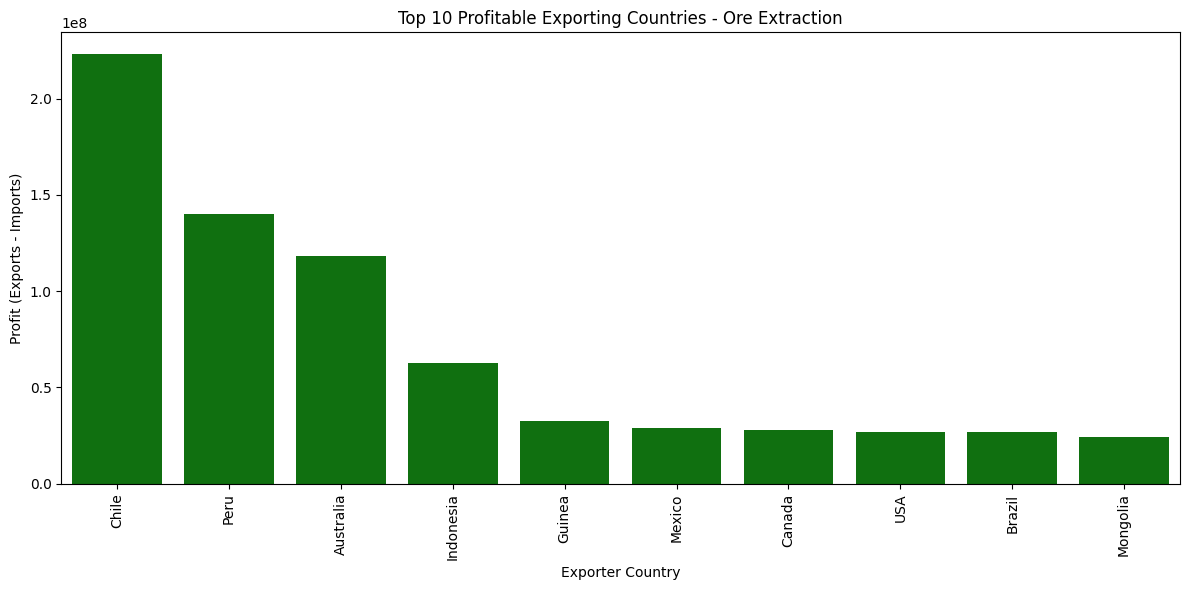


==== Calculating export-import profit for Refining ====


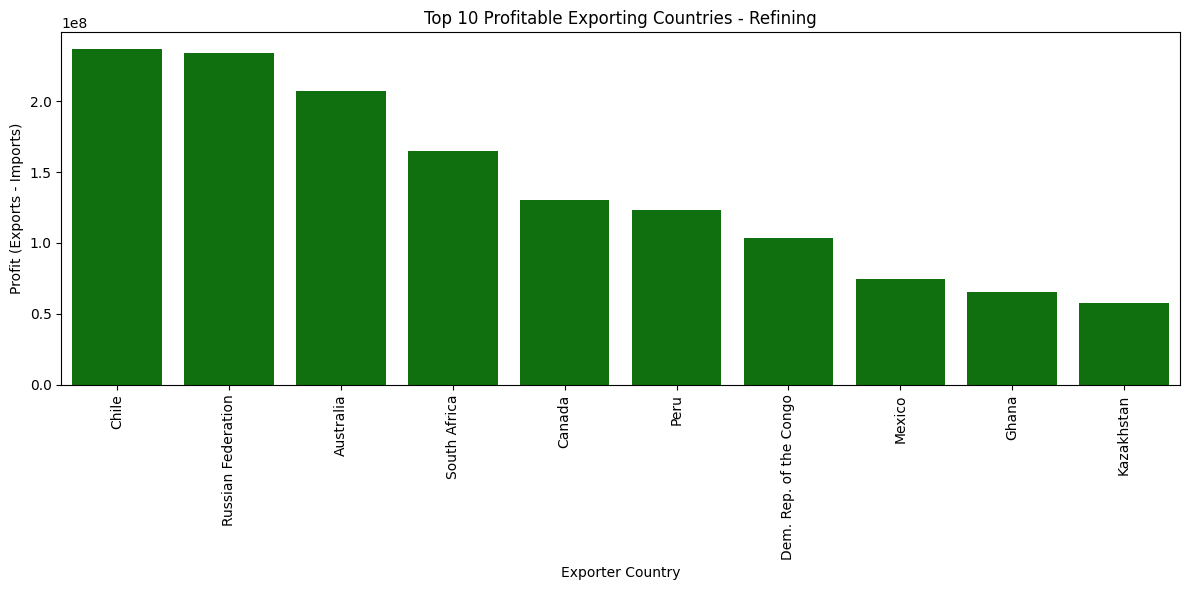


==== Calculating export-import profit for Manufacturing ====


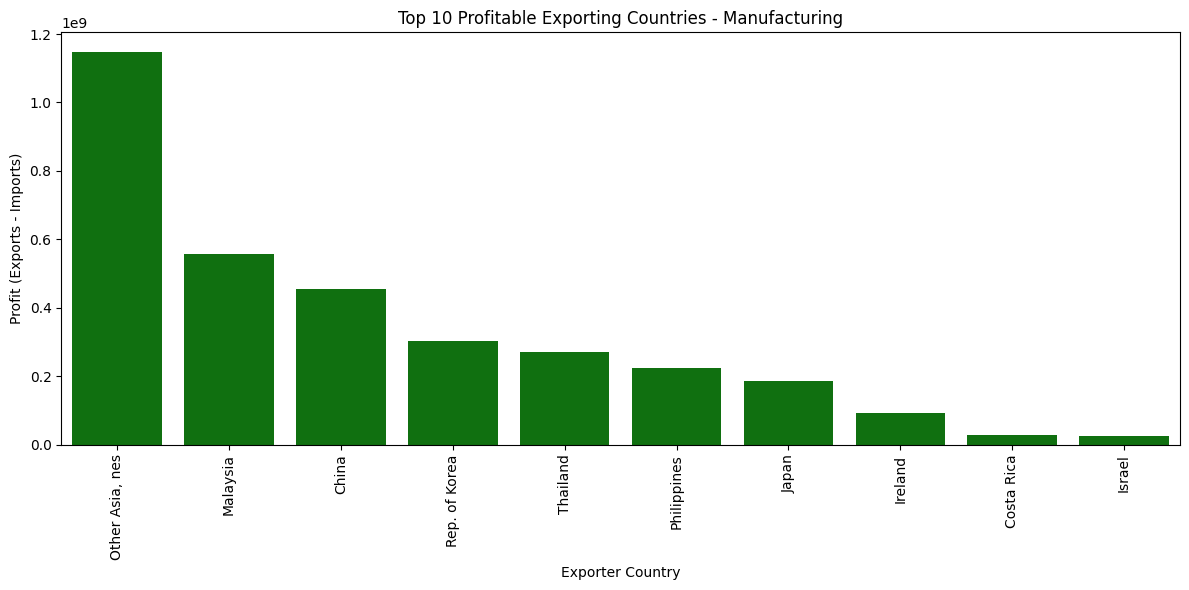


==== Calculating export-import profit for Mining ====


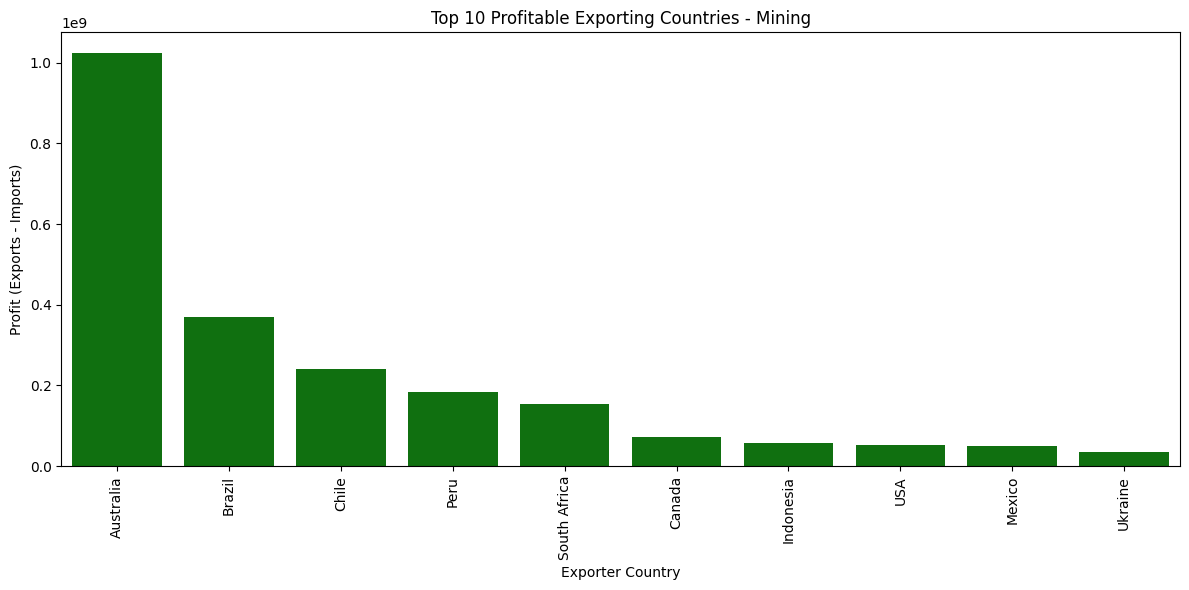

In [40]:
for name, df in dfs:
    print(f"\n==== Calculating export-import profit for {name} ====")

    # Exports by country
    df_exports = df.groupby('Exporter_Name').agg({'Value': 'sum'}).reset_index()
    df_exports.rename(columns={'Value': 'Export_Value'}, inplace=True)

    # Imports by the same countries (treated as if they were also importers)
    df_imports = df.groupby('Importer_Name').agg({'Value': 'sum'}).reset_index()
    df_imports.rename(columns={'Value': 'Import_Value'}, inplace=True)

    # Merge and calculate profit
    df_profit = df_exports.merge(df_imports, left_on='Exporter_Name', right_on='Importer_Name', how='left').fillna(0)
    df_profit['Profit'] = df_profit['Export_Value'] - df_profit['Import_Value']

    top_profitable = df_profit.nlargest(10, 'Profit')

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Exporter_Name', y='Profit', data=top_profitable, color='green')
    plt.xticks(rotation=90)
    plt.ylabel("Profit (Exports - Imports)")
    plt.xlabel("Exporter Country")
    plt.title(f"Top 10 Profitable Exporting Countries - {name}")
    plt.tight_layout()
    plt.show()



==== Calculating least profitable importers for Ore Extraction ====


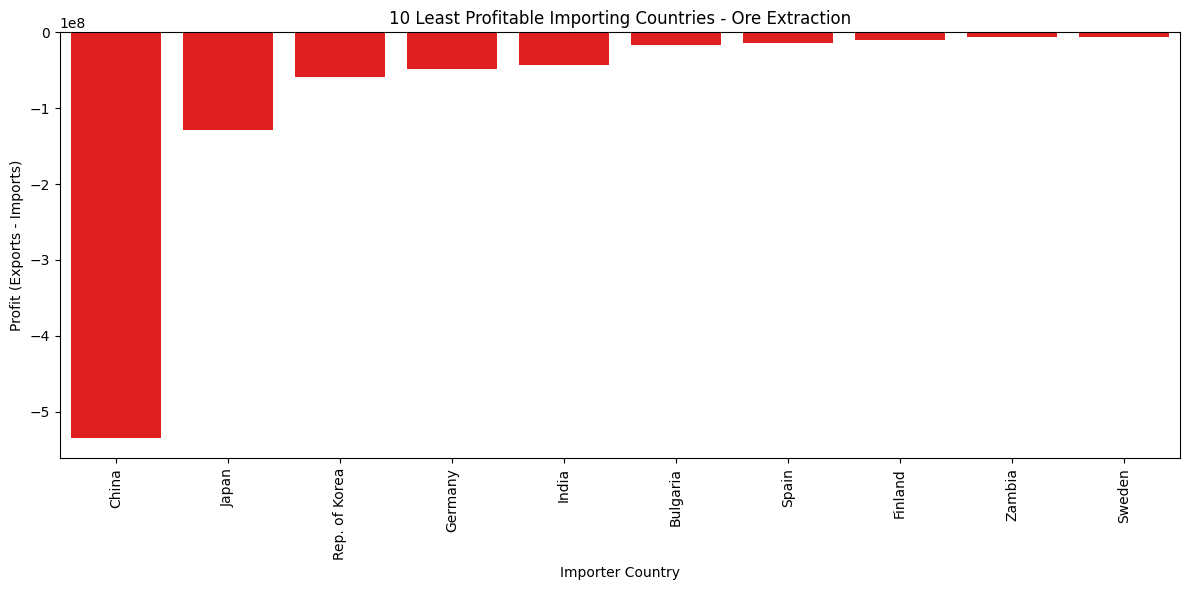


==== Calculating least profitable importers for Refining ====


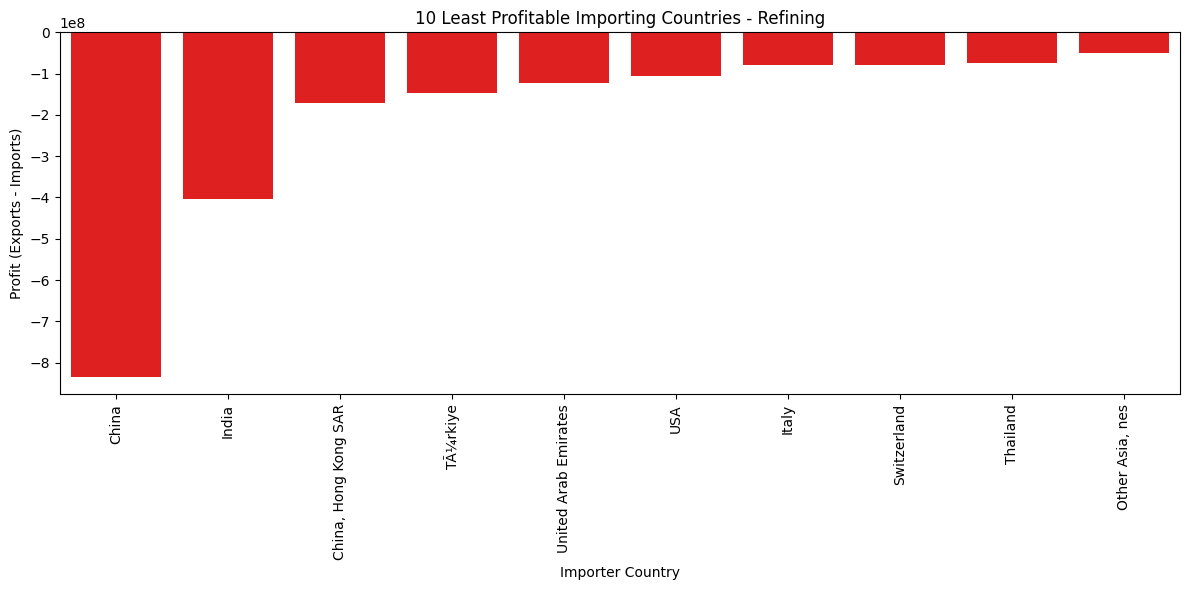


==== Calculating least profitable importers for Manufacturing ====


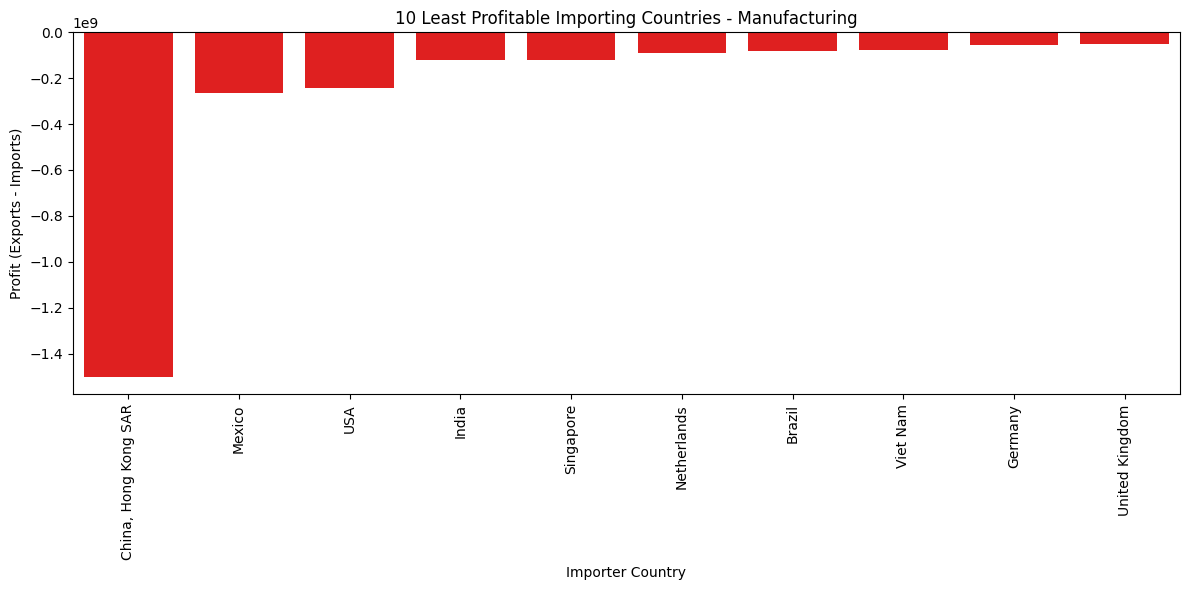


==== Calculating least profitable importers for Mining ====


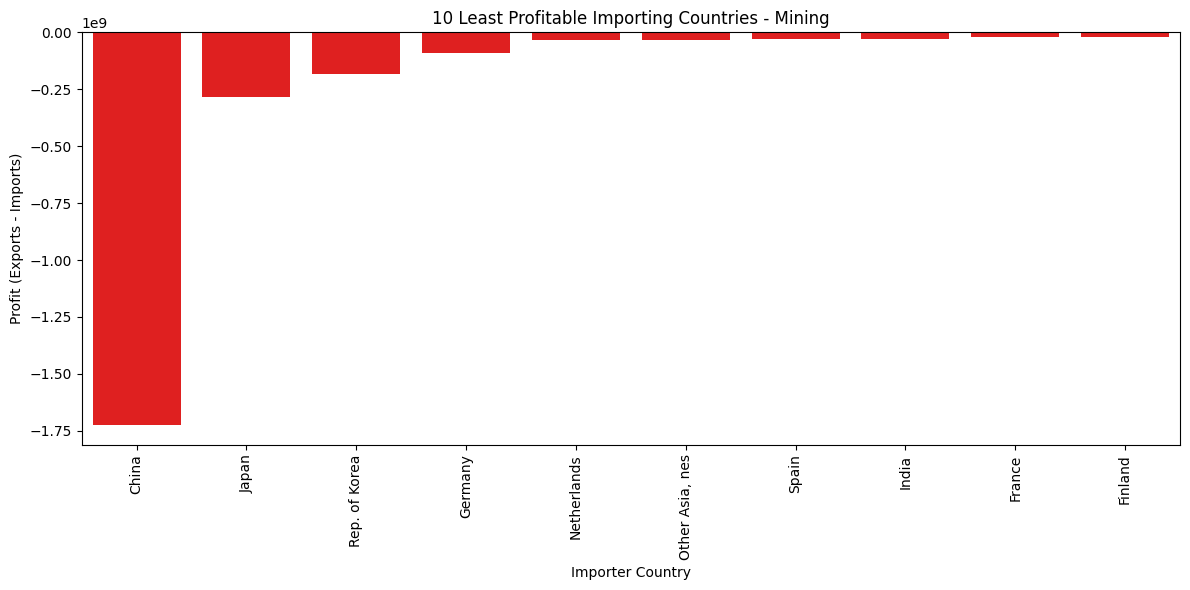

In [42]:
for name, df in dfs:
    print(f"\n==== Calculating least profitable importers for {name} ====")

    # Exports and Imports
    df_exports = df.groupby('Exporter_Name').agg({'Value': 'sum'}).reset_index()
    df_exports.rename(columns={'Value': 'Export_Value'}, inplace=True)

    df_imports = df.groupby('Importer_Name').agg({'Value': 'sum'}).reset_index()
    df_imports.rename(columns={'Value': 'Import_Value'}, inplace=True)

    # Profit = Exports - Imports by mapping Exporter_Name with Importer_Name
    df_profit = df_imports.merge(df_exports, left_on='Importer_Name', right_on='Exporter_Name', how='left').fillna(0)
    df_profit['Profit'] = df_profit['Export_Value'] - df_profit['Import_Value']

    # Get bottom 10
    least_profitable = df_profit.nsmallest(10, 'Profit')

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importer_Name', y='Profit', data=least_profitable, color='red')
    plt.xticks(rotation=90)
    plt.ylabel("Profit (Exports - Imports)")
    plt.xlabel("Importer Country")
    plt.title(f"10 Least Profitable Importing Countries - {name}")
    plt.tight_layout()
    plt.show()


In [ ]:
import plotly.graph_objects as go

dfs = [
    ("Ore Extraction", df_ore_extraction),
    ("Refining", df_refining),
    ("Manufacturing", df_manufacturing),
    ("Mining", df_mining)
]

for name, df_subset in dfs:
    print(f"\n==== Generating Sankey for: {name} ====")

    # Label source (Exporter), target (Importer)
    df_subset = df_subset.copy()
    df_subset = df_subset[df_subset["Exporter_Name"].notnull() & df_subset["Importer_Name"].notnull()]
    
    # Create node labels (unique list of all countries involved)
    all_countries = pd.Series(
        pd.concat([df_subset["Exporter_Name"], df_subset["Importer_Name"]]).unique()
    ).reset_index(drop=True)

    label_to_index = {label: i for i, label in enumerate(all_countries)}

    # Construct source, target, and value arrays
    source = df_subset["Exporter_Name"].map(label_to_index)
    target = df_subset["Importer_Name"].map(label_to_index)
    value = df_subset["Value"]

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_countries.tolist()
        ),
        link=dict(
            source=source,
            target=target,
            value=value
        )
    )])

    fig.update_layout(title_text=f"Sankey Diagram - {name}", font_size=10)
    fig.show()


In [43]:
def get_top_trading_partners(country, df):
    exports = df[df['Exporter_Name'] == country].groupby('Importer_Name').agg({'Value': 'sum'}).nlargest(5, 'Value').reset_index()
    imports = df[df['Importer_Name'] == country].groupby('Exporter_Name').agg({'Value': 'sum'}).nlargest(5, 'Value').reset_index()
    return exports, imports




In [44]:
for country in top_profitable['Exporter_Name']:
  top_export_partners, top_import_partners = get_top_trading_partners(country, df)

  print(f"Top 5 export partners for {country}:\n", top_export_partners)
  print(f"Top 5 import partners for {country}:\n", top_import_partners)

Top 5 export partners for Australia:
      Importer_Name         Value
0            China  7.766909e+08
1            Japan  1.043998e+08
2    Rep. of Korea  7.865753e+07
3  Other Asia, nes  2.110845e+07
4            India  1.020645e+07
Top 5 import partners for Australia:
                       Exporter_Name        Value
0                            Mexico  1893235.065
1  Bolivia (Plurinational State of)  1528961.158
2                               USA  1386931.067
3                             Chile  1293788.630
4            Lao People's Dem. Rep.   953820.541
Top 5 export partners for Brazil:
    Importer_Name         Value
0          China  1.906534e+08
1          Japan  3.081369e+07
2        Germany  1.504630e+07
3       Malaysia  1.423312e+07
4  Rep. of Korea  1.375443e+07
Top 5 import partners for Brazil:
   Exporter_Name        Value
0         Chile  5072250.583
1          Peru  4082036.961
2  South Africa   307444.927
3        Panama   223779.857
4           USA   178877.590
To

In [10]:
for country in least_profitable['Importer_Name']:
  top_export_partners, top_import_partners = get_top_trading_partners(country, df)

  print(f"Top 5 export partners for {country}:\n", top_export_partners)
  print(f"Top 5 import partners for {country}:\n", top_import_partners)

Top 5 export partners for USA:
           Importer_Name         Value
0                Canada  1.405649e+08
1                Mexico  1.230302e+08
2                 China  6.967542e+07
3  China, Hong Kong SAR  6.237681e+07
4           Netherlands  5.575723e+07
Top 5 import partners for USA:
      Exporter_Name         Value
0            China  2.097615e+09
1           Mexico  7.141932e+08
2         Viet Nam  1.948137e+08
3         Thailand  1.512588e+08
4  Other Asia, nes  1.430191e+08
Top 5 export partners for China, Hong Kong SAR:
   Importer_Name         Value
0   Netherlands  3.731699e+07
1         India  1.753401e+07
2      Malaysia  9.545505e+06
3           USA  9.117367e+06
4         China  8.833693e+06
Top 5 import partners for China, Hong Kong SAR:
      Exporter_Name         Value
0            China  8.444648e+08
1              USA  6.237681e+07
2         Thailand  3.455546e+07
3            Japan  2.782890e+07
4  Other Asia, nes  1.987216e+07
Top 5 export partners for United K

In [11]:
df_profit

Exporter_Name         Value   Quantity_x  \
0               Afghanistan  4.087730e+04     2831.705   
1                   Albania  1.631109e+05    19949.346   
2                   Algeria  3.382657e+05    68162.785   
3            American Samoa  1.043787e+04      216.414   
4                   Andorra  1.145795e+05     3337.957   
..                      ...           ...          ...   
222                Viet Nam  7.918991e+08  9923828.257   
223  Wallis and Futuna Isds  9.732090e+02       44.622   
224                   Yemen  1.439128e+04      926.701   
225                  Zambia  3.977712e+05     8526.775   
226                Zimbabwe  6.014013e+04     9419.739   

              Importer_Name  Import_Value   Quantity_y        Profit  
0               Afghanistan  1.106789e+07   189564.184 -1.102701e+07  
1                   Albania  3.536450e+06   291357.972 -3.373340e+06  
2                   Algeria  2.997479e+07  2002250.551 -2.963653e+07  
3            American Samoa  2.288845e+04      395.692 -1.245058e+04  
4                   Andorra  1.404799e+06    34604.667 -1.290220e+06  
..                      ...           ...          ...           ...  
222                Viet Nam  1.519051e+08  5654744.243  6.399940e+08  
223  Wallis and Futuna Isds  2.468093e+04     9082.645 -2.370772e+04  
224                   Yemen  3.007101e+06   384472.351 -2.992709e+06  
225                  Zambia  3.936750e+06   194379.848 -3.538979e+06  
226                Zimbabwe  3.168768e+06   134407.773 -3.108628e+06  

[227 rows x 7 columns]

BY REGION


==== Regional trade analysis for: Ore Extraction ====


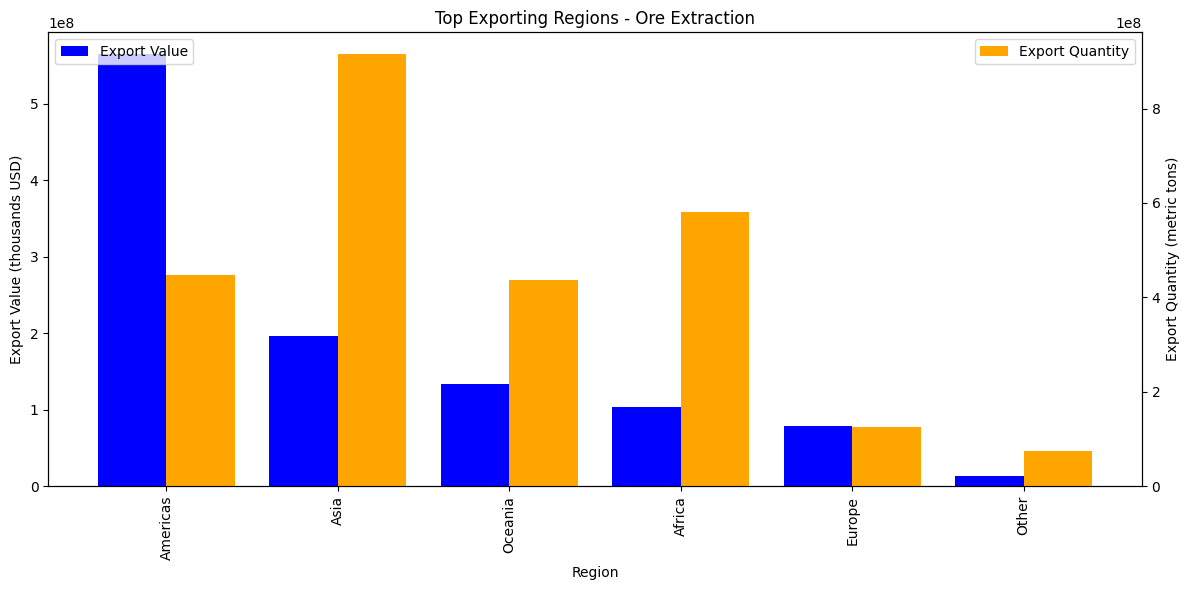

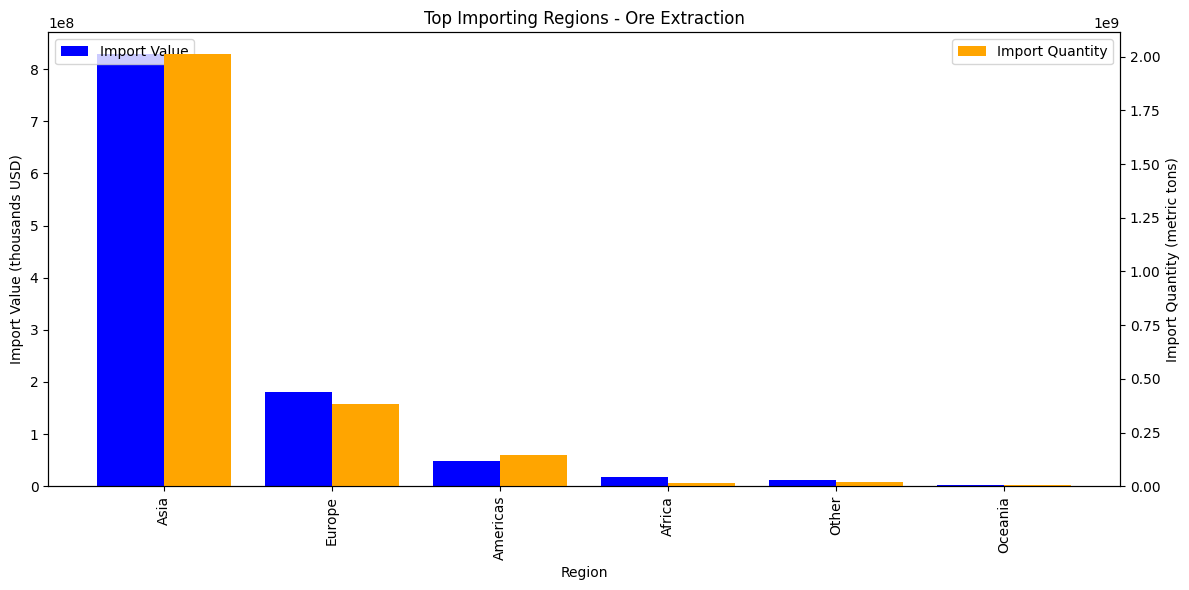

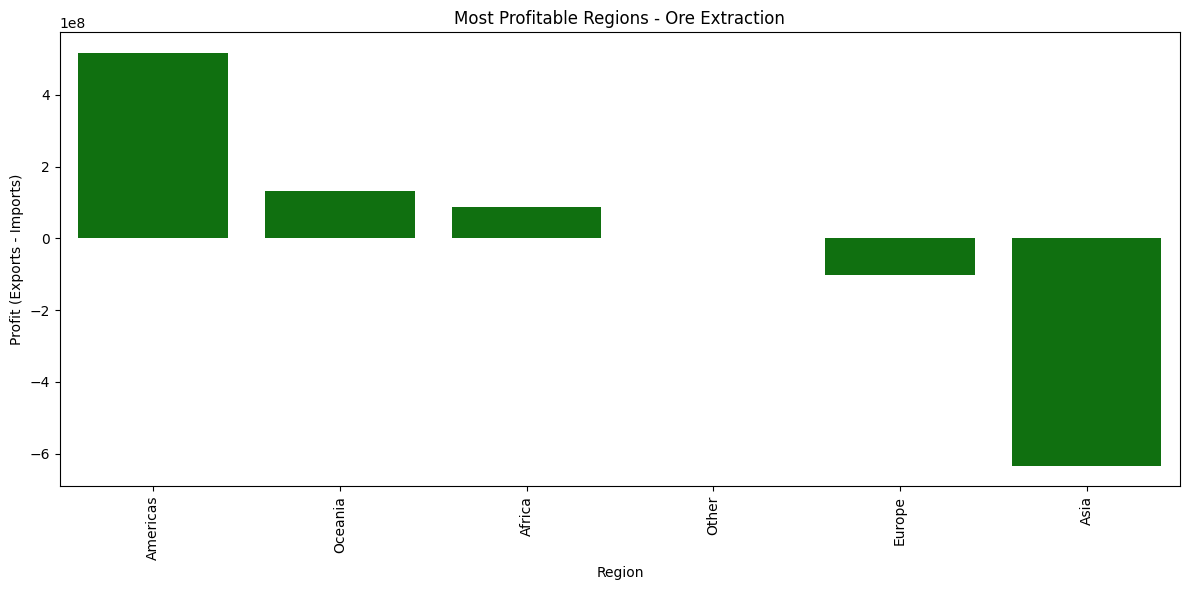


==== Regional trade analysis for: Refining ====


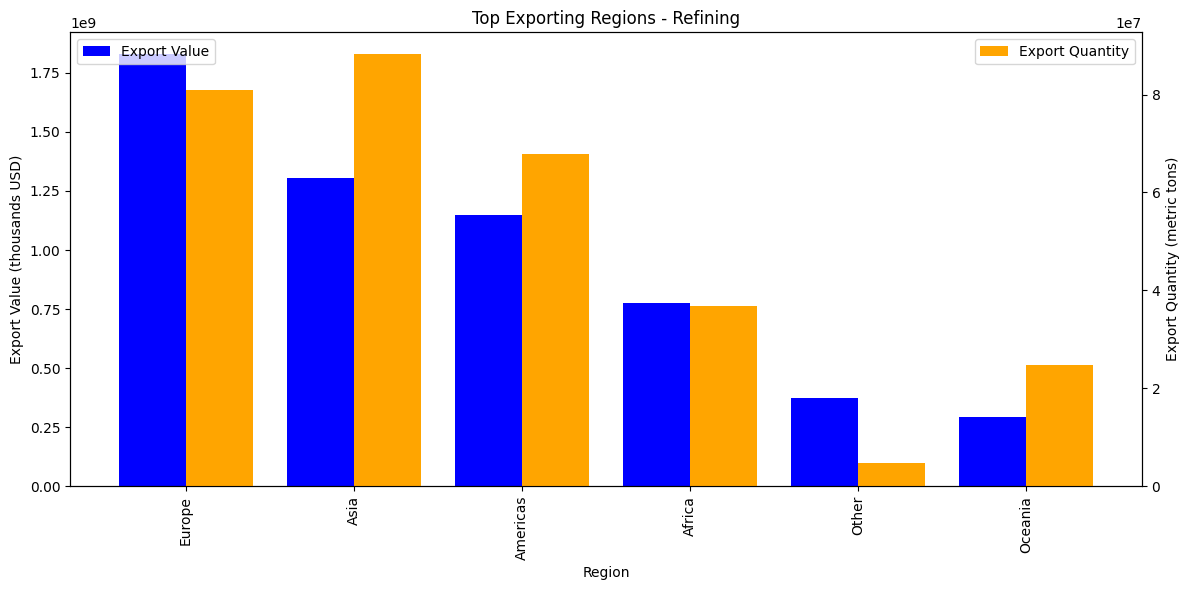

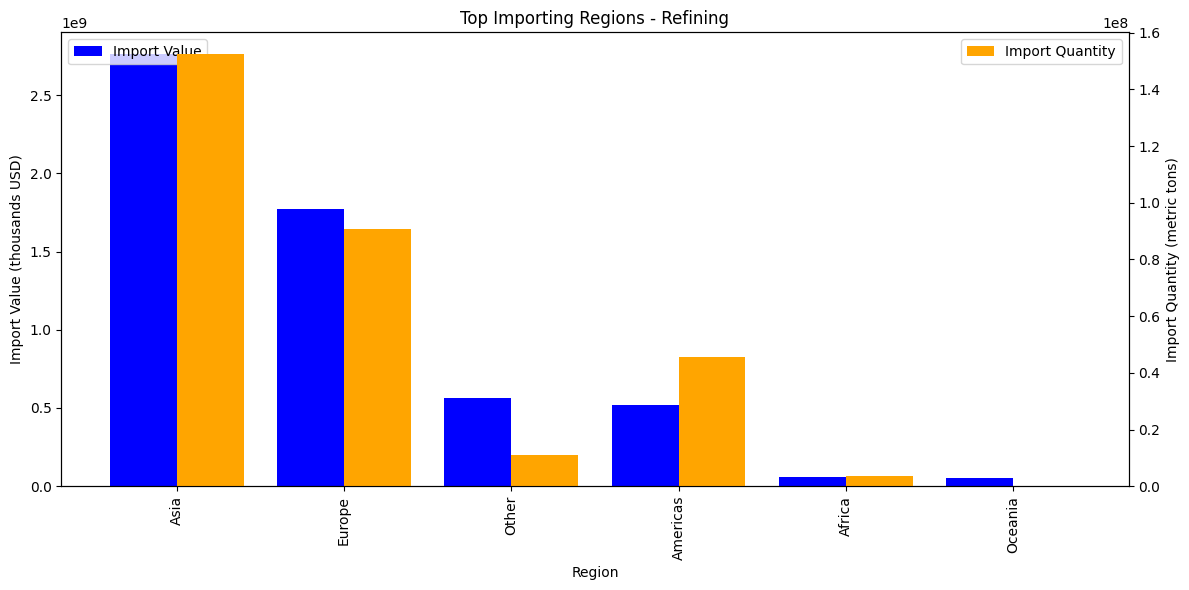

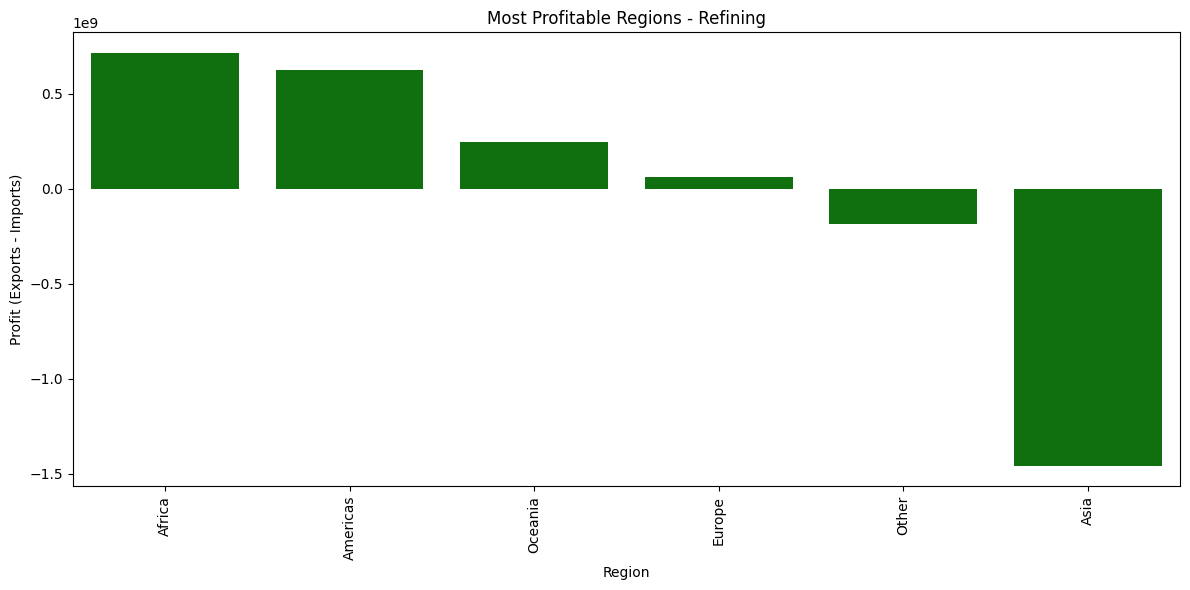


==== Regional trade analysis for: Manufacturing ====


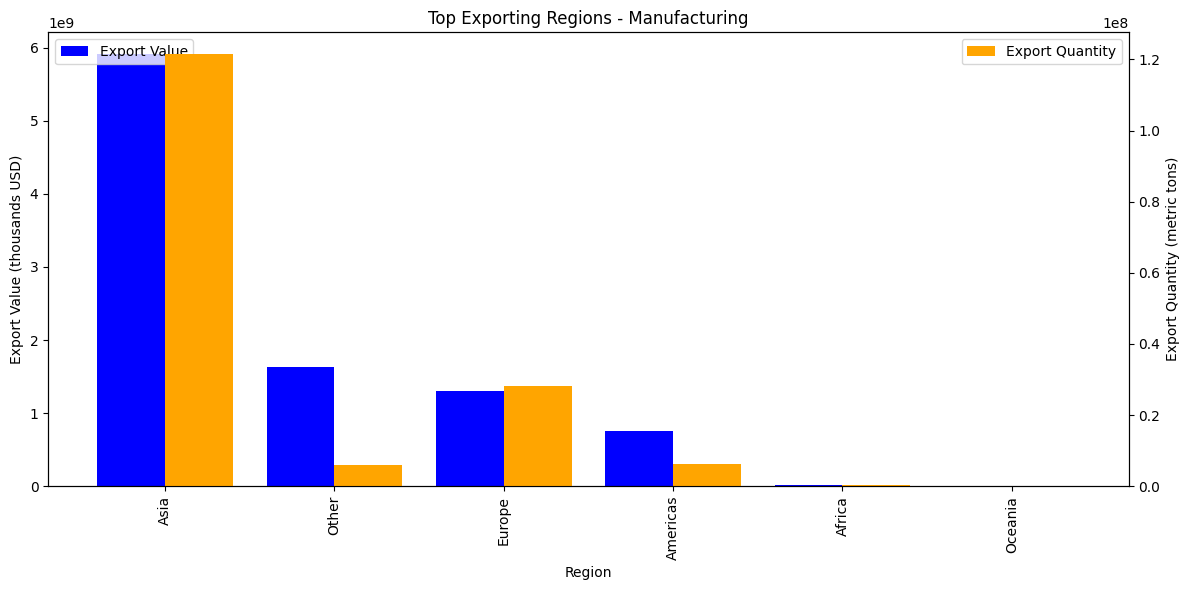

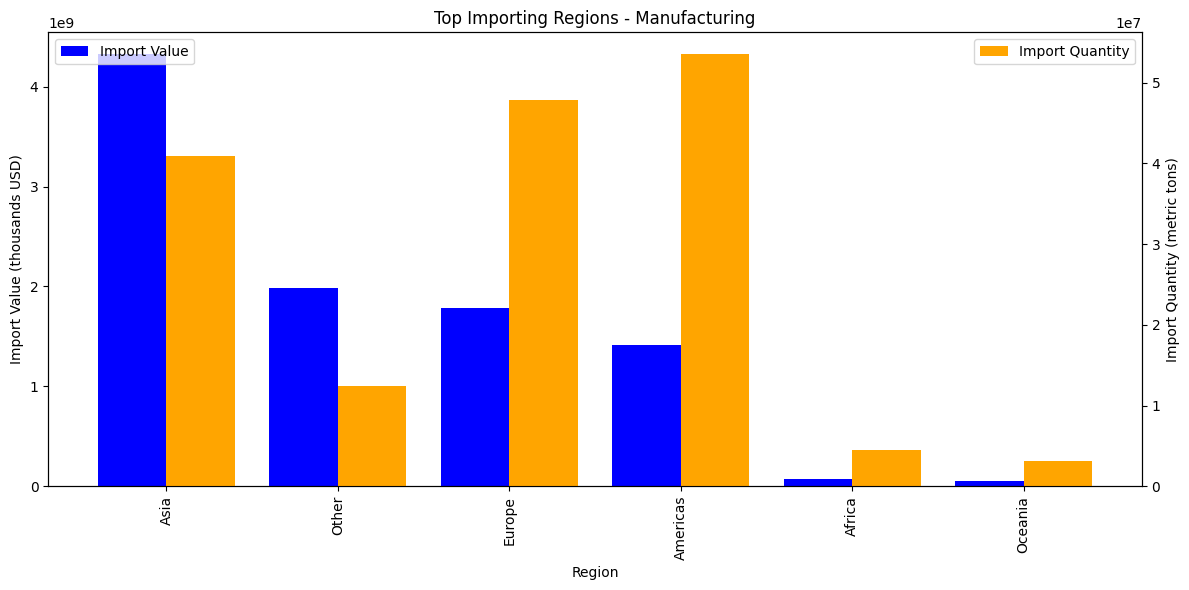

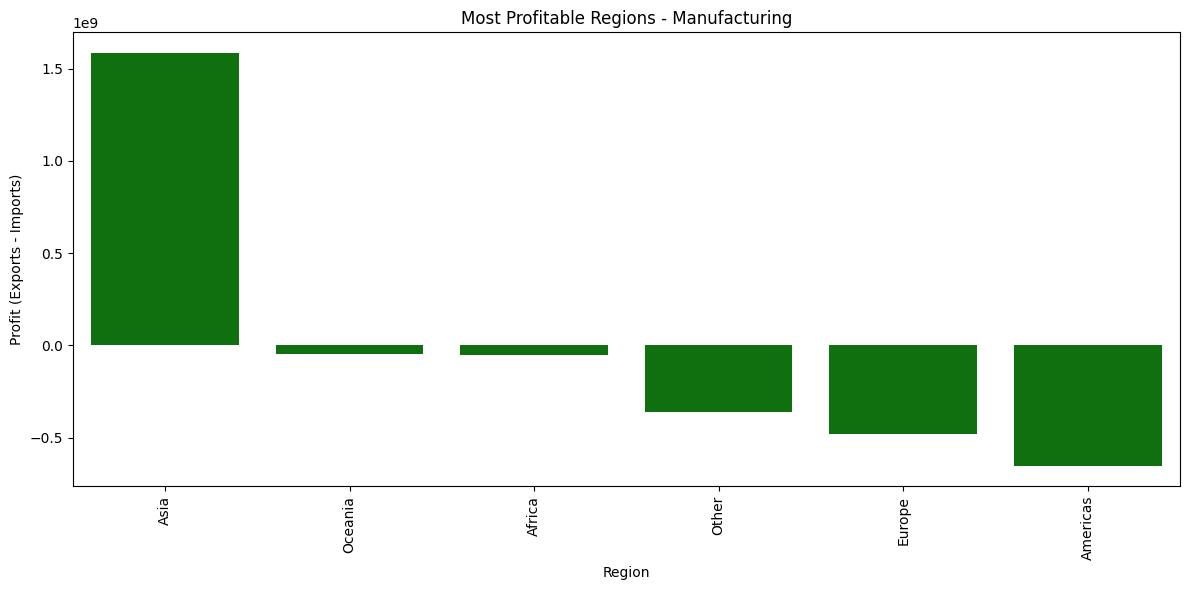


==== Regional trade analysis for: Mining ====


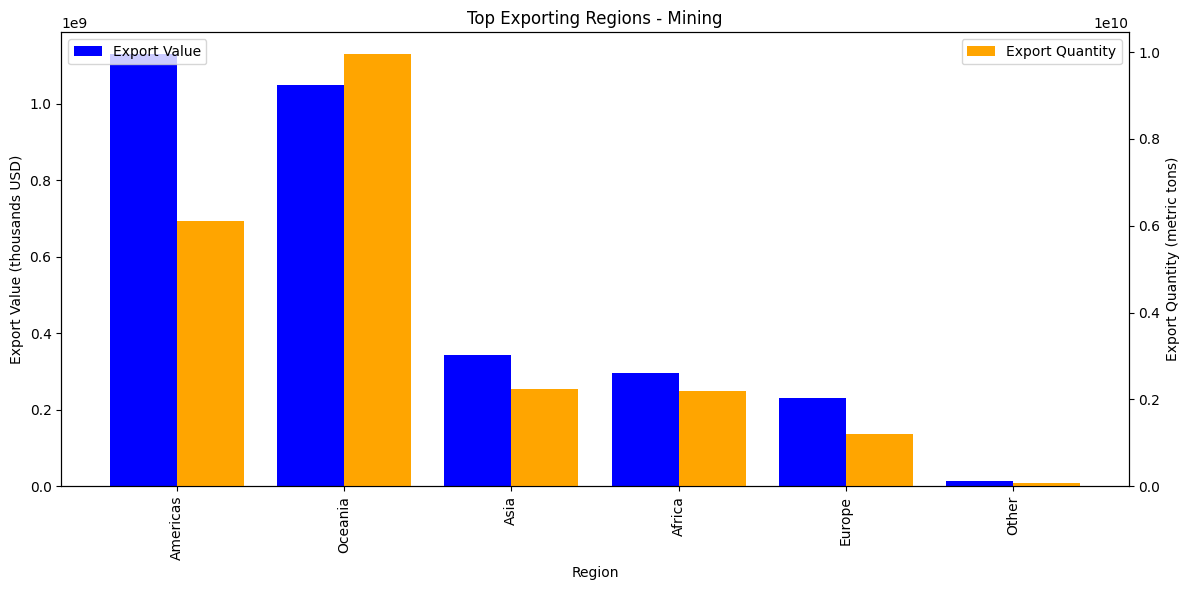

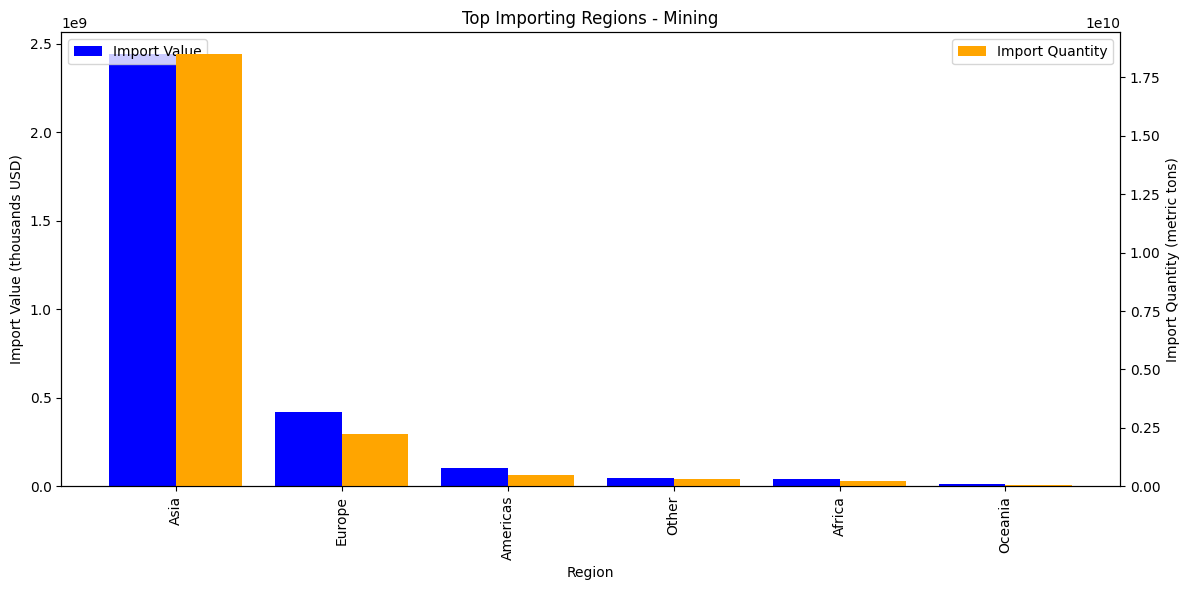

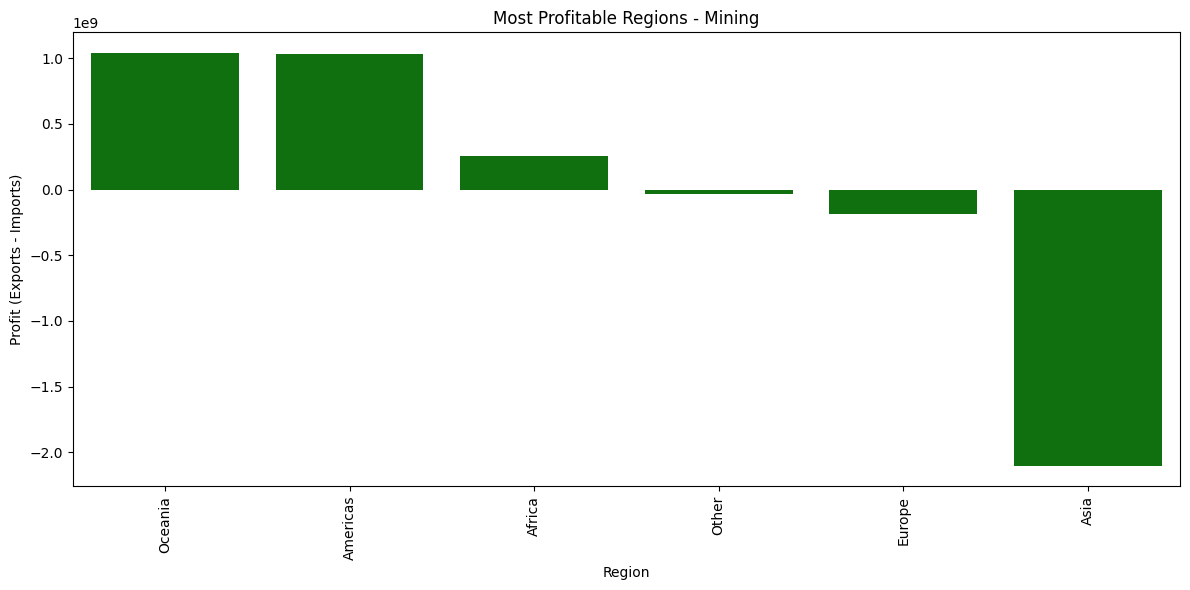


==== Regional trade analysis for: Full Dataset ====


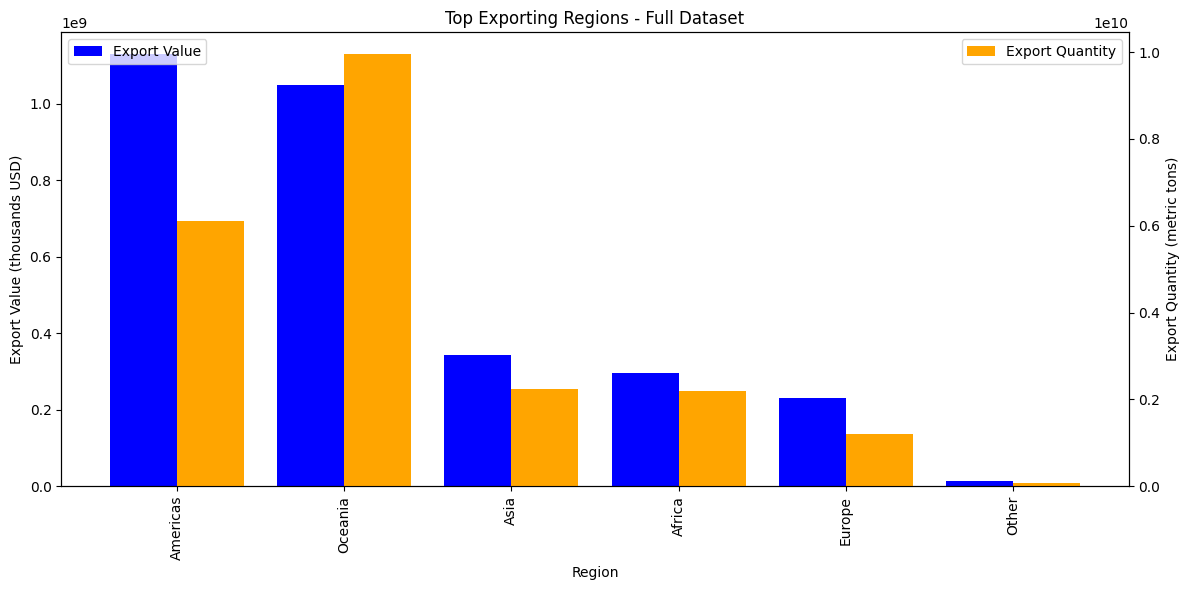

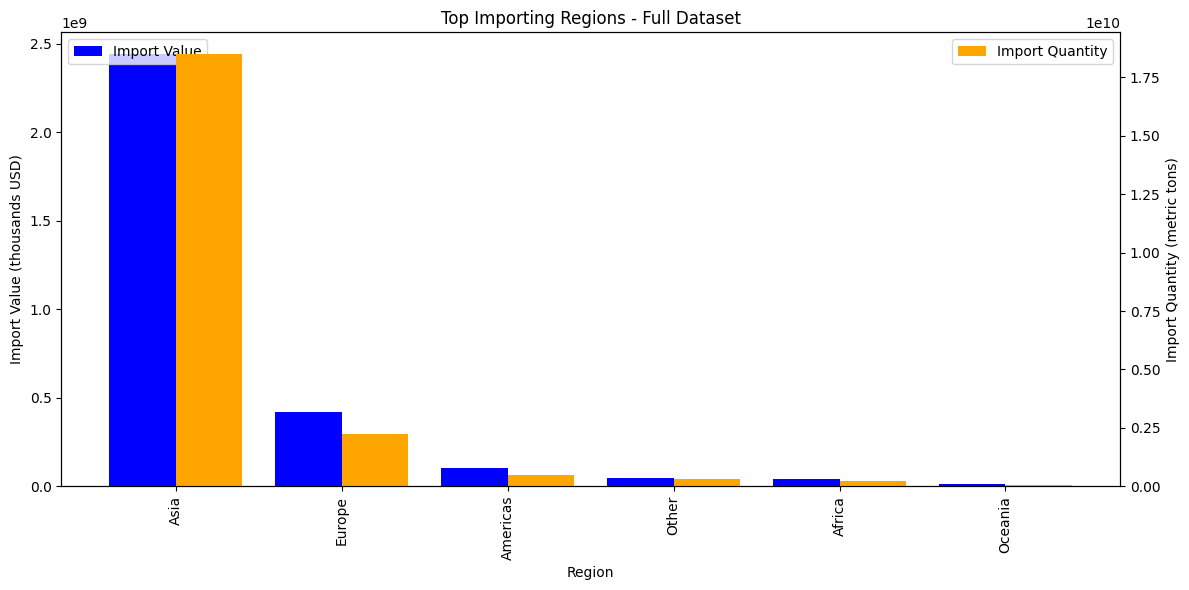

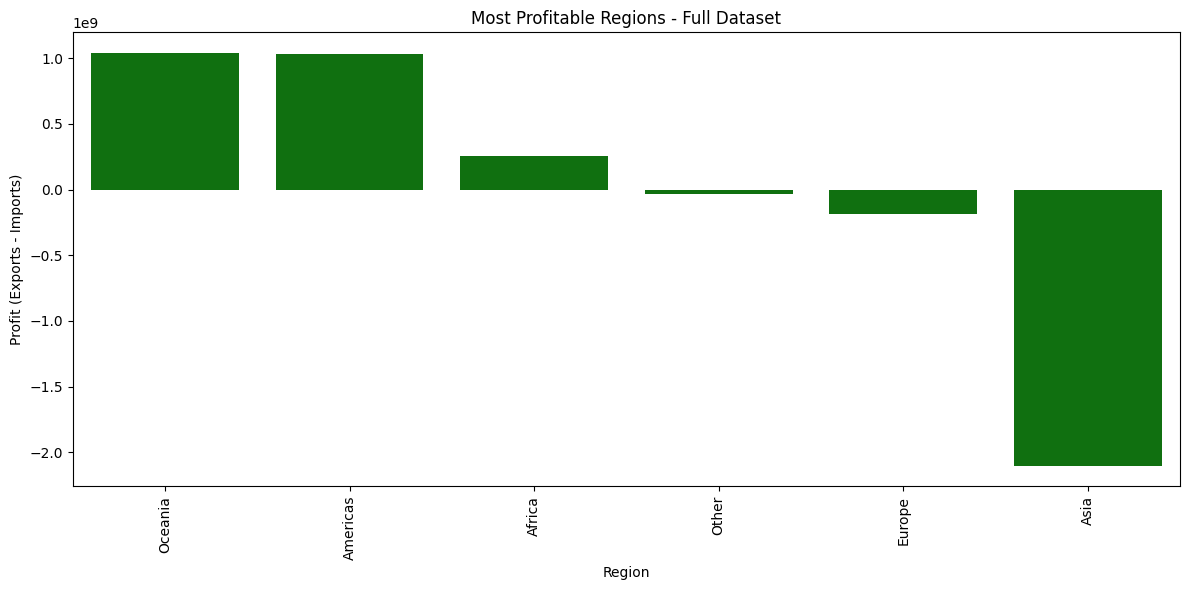

In [45]:
dfs = [
    ("Ore Extraction", df_ore_extraction),
    ("Refining", df_refining),
    ("Manufacturing", df_manufacturing),
    ("Mining", df_mining),
    ("Full Dataset", df)  # optional full view
]

# ISO to Region mapping
iso_to_region = {
    'Africa': ["DZA", "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR", "CAF", "TCD", "COM", "COD", "DJI", "EGY", "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA", "GIN", "GNB", "CIV", "KEN", "LSO", "LBR", "LBY", "MDG", "MWI", "MLI", "MRT", "MUS", "MAR", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", "SEN", "SYC", "SLE", "SOM", "ZAF", "SSD", "SDN", "TZA", "TGO", "TUN", "UGA", "ZMB", "ZWE"],
    'Americas': ["ATG", "ARG", "BHS", "BRB", "BLZ", "BOL", "BRA", "CAN", "CHL", "COL", "CRI", "CUB", "DMA", "DOM", "ECU", "SLV", "GRD", "GTM", "GUY", "HTI", "HND", "JAM", "MEX", "NIC", "PAN", "PRY", "PER", "KNA", "LCA", "VCT", "SUR", "TTO", "USA", "URY", "VEN"],
    'Asia': ["AFG", "ARM", "AZE", "BHR", "BGD", "BTN", "BRN", "KHM", "CHN", "CYP", "GEO", "IND", "IDN", "IRN", "IRQ", "ISR", "JPN", "JOR", "KAZ", "KWT", "KGZ", "LAO", "LBN", "MYS", "MDV", "MNG", "MMR", "NPL", "PRK", "OMN", "PAK", "PSE", "PHL", "QAT", "SAU", "SGP", "KOR", "LKA", "SYR", "TJK", "THA", "TLS", "TUR", "TKM", "ARE", "UZB", "VNM", "YEM"],
    'Europe': ["ALB", "AND", "AUT", "BLR", "BEL", "BIH", "BGR", "HRV", "CZE", "DNK", "EST", "FIN", "FRA", "DEU", "GRC", "HUN", "ISL", "IRL", "ITA", "LVA", "LIE", "LTU", "LUX", "MLT", "MDA", "MCO", "MNE", "NLD", "MKD", "NOR", "POL", "PRT", "ROU", "RUS", "SMR", "SRB", "SVK", "SVN", "ESP", "SWE", "CHE", "UKR", "GBR", "VAT"],
    'Oceania': ["AUS", "FJI", "KIR", "MHL", "FSM", "NRU", "NZL", "PLW", "PNG", "WSM", "SLB", "TON", "TUV", "VUT"]
}

def get_region(iso_code):
    for region, iso_list in iso_to_region.items():
        if iso_code in iso_list:
            return region
    return 'Other'

# Run region analysis for each data category
for name, df_subset in dfs:
    print(f"\n==== Regional trade analysis for: {name} ====")
    
    df_subset = df_subset.copy()
    df_subset['Exporter_Region'] = df_subset['country_iso3_x'].apply(get_region)
    df_subset['Importer_Region'] = df_subset['country_iso3_y'].apply(get_region)
    
    # Exports
    df_region_exports = df_subset.groupby('Exporter_Region').agg({'Value': 'sum', 'Quantity': 'sum'}).reset_index()
    top_exporters = df_region_exports.nlargest(10, 'Value')

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    width = 0.4
    x = range(len(top_exporters))

    ax1.bar([p - width/2 for p in x], top_exporters['Value'], width=width, color='blue', label='Export Value')
    ax2.bar([p + width/2 for p in x], top_exporters['Quantity'], width=width, color='orange', label='Export Quantity')

    ax1.set_xticks(x)
    ax1.set_xticklabels(top_exporters['Exporter_Region'], rotation=90)
    ax1.set_ylabel("Export Value (thousands USD)")
    ax2.set_ylabel("Export Quantity (metric tons)")
    ax1.set_xlabel("Region")
    plt.title(f"Top Exporting Regions - {name}")
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # Imports
    df_region_imports = df_subset.groupby('Importer_Region').agg({'Value': 'sum', 'Quantity': 'sum'}).reset_index()
    top_importers = df_region_imports.nlargest(10, 'Value')

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    ax1.bar([p - width/2 for p in x], top_importers['Value'], width=width, color='blue', label='Import Value')
    ax2.bar([p + width/2 for p in x], top_importers['Quantity'], width=width, color='orange', label='Import Quantity')

    ax1.set_xticks(x)
    ax1.set_xticklabels(top_importers['Importer_Region'], rotation=90)
    ax1.set_ylabel("Import Value (thousands USD)")
    ax2.set_ylabel("Import Quantity (metric tons)")
    ax1.set_xlabel("Region")
    plt.title(f"Top Importing Regions - {name}")
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # Regional Profit
    df_region_exports.rename(columns={'Value': 'Export_Value'}, inplace=True)
    df_region_imports.rename(columns={'Value': 'Import_Value'}, inplace=True)

    df_profit = df_region_exports.merge(df_region_imports, left_on='Exporter_Region', right_on='Importer_Region', how='left').fillna(0)
    df_profit['Profit'] = df_profit['Export_Value'] - df_profit['Import_Value']

    top_profitable = df_profit.nlargest(10, 'Profit')

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Exporter_Region', y='Profit', data=top_profitable, color='green')
    plt.xticks(rotation=90)
    plt.ylabel("Profit (Exports - Imports)")
    plt.xlabel("Region")
    plt.title(f"Most Profitable Regions - {name}")
    plt.tight_layout()
    plt.show()


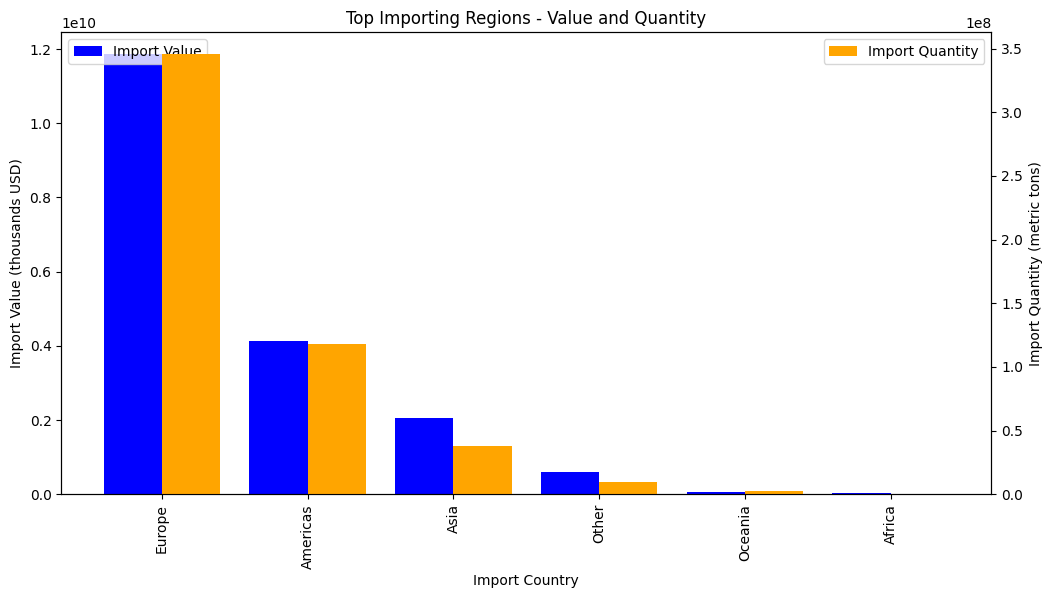

In [15]:
df_region_imports = df.groupby('Importer_Region').agg({'Value': 'sum', 'Quantity': 'sum'}).reset_index()

top_importers = df_region_imports.nlargest(10, 'Value')

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

width = 0.4
x = range(len(top_importers))

ax1.bar([p - width/2 for p in x], top_exporters['Value'], width=width, color='blue', label='Import Value')
ax2.bar([p + width/2 for p in x], top_exporters['Quantity'], width=width, color='orange', label='Import Quantity')

ax1.set_xticks(x)
ax1.set_xticklabels(top_importers['Importer_Region'], rotation=90)
ax1.set_ylabel("Import Value (thousands USD)")
ax2.set_ylabel("Import Quantity (metric tons)")
ax1.set_xlabel("Import Country")
plt.title("Top Importing Regions - Value and Quantity")

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


In [17]:
def get_top_trading_partners(region, df):
    exports = df_global[df_global['Exporter_Region'] == region].groupby('Importer_Region').agg({'Value': 'sum'}).nlargest(5, 'Value').reset_index()
    imports = df_global[df_global['Importer_Region'] == region].groupby('Exporter_Region').agg({'Value': 'sum'}).nlargest(5, 'Value').reset_index()
    return exports, imports


In [18]:
for region in top_profitable['Exporter_Region']:
  top_export_partners, top_import_partners = get_top_trading_partners(region, df)

  print(f"Top 5 export regions for {region}:\n", top_export_partners)
  print(f"Top 5 import regions for {region}:\n", top_import_partners)

Top 5 export regions for Asia:
   Importer_Region         Value
0        Americas  3.782842e+09
1            Asia  3.405991e+09
2          Europe  2.992970e+09
3           Other  1.132629e+09
4         Oceania  2.946146e+08
Top 5 import regions for Asia:
   Exporter_Region         Value
0            Asia  3.405991e+09
1          Europe  5.275469e+08
2        Americas  3.241945e+08
3           Other  1.911385e+08
4          Africa  1.109930e+07
Top 5 export regions for Africa:
   Importer_Region         Value
0          Europe  1.780101e+07
1          Africa  1.750245e+07
2            Asia  1.109930e+07
3        Americas  1.780554e+06
4           Other  7.357958e+05
Top 5 import regions for Africa:
   Exporter_Region         Value
0            Asia  2.477156e+08
1          Europe  8.307243e+07
2        Americas  1.793289e+07
3          Africa  1.750245e+07
4           Other  1.490744e+07
Top 5 export regions for Oceania:
   Importer_Region        Value
0        Americas  8065489.539
1  

In [19]:
df_global

Year  Exporter  Importer  Product   Value  Quantity  \
64         2014         4        36   844332  24.087     0.045   
65         2014         4        36   847130   1.869     0.002   
66         2014         4        36   847141   2.295     0.005   
70         2014         4        36   851762   5.910     0.168   
139        2014         4        40   846721   1.333     0.015   
...         ...       ...       ...      ...     ...       ...   
130258829  2013       894       842   847180  31.450     0.140   
130258845  2013       894       842   851769   0.499     0.002   
130258861  2013       894       842   902620   0.324     0.002   
130258862  2013       894       842   902780   2.019     0.007   
130258866  2013       894       842   903180   2.940     0.013   

           country_code_x Exporter_Name country_iso2_x country_iso3_x  \
64                      4   Afghanistan             AF            AFG   
65                      4   Afghanistan             AF            AFG   
66                      4   Afghanistan             AF            AFG   
70                      4   Afghanistan             AF            AFG   
139                     4   Afghanistan             AF            AFG   
...                   ...           ...            ...            ...   
130258829             894        Zambia             ZM            ZMB   
130258845             894        Zambia             ZM            ZMB   
130258861             894        Zambia             ZM            ZMB   
130258862             894        Zambia             ZM            ZMB   
130258866             894        Zambia             ZM            ZMB   

           country_code_y Importer_Name country_iso2_y country_iso3_y  \
64                     36     Australia             AU            AUS   
65                     36     Australia             AU            AUS   
66                     36     Australia             AU            AUS   
70                     36     Australia             AU            AUS   
139                    40       Austria             AT            AUT   
...                   ...           ...            ...            ...   
130258829             842           USA             US            USA   
130258845             842           USA             US            USA   
130258861             842           USA             US            USA   
130258862             842           USA             US            USA   
130258866             842           USA             US            USA   

                                                 description Exporter_Region  \
64         Printing, copying, and facsimile machines: sin...            Asia   
65         Automatic data processing machines: portable, ...            Asia   
66         Automatic data processing machines: comprising...            Asia   
70         Communication apparatus (excluding telephone s...            Asia   
139        Tools: for working in the hand, with self-cont...            Asia   
...                                                      ...             ...   
130258829  Units of automatic data processing machines: n...          Africa   
130258845  Communication apparatus (excluding telephone s...          Africa   
130258861  Instruments and apparatus: for measuring or ch...          Africa   
130258862  Instruments and apparatus: for physical or che...          Africa   
130258866  Instruments, appliances and machines: for meas...          Africa   

          Importer_Region  
64                Oceania  
65                Oceania  
66                Oceania  
70                Oceania  
139                Europe  
...                   ...  
130258829        Americas  
130258845        Americas  
130258861        Americas  
130258862        Americas  
130258866        Americas  

[8047410 rows x 17 columns]

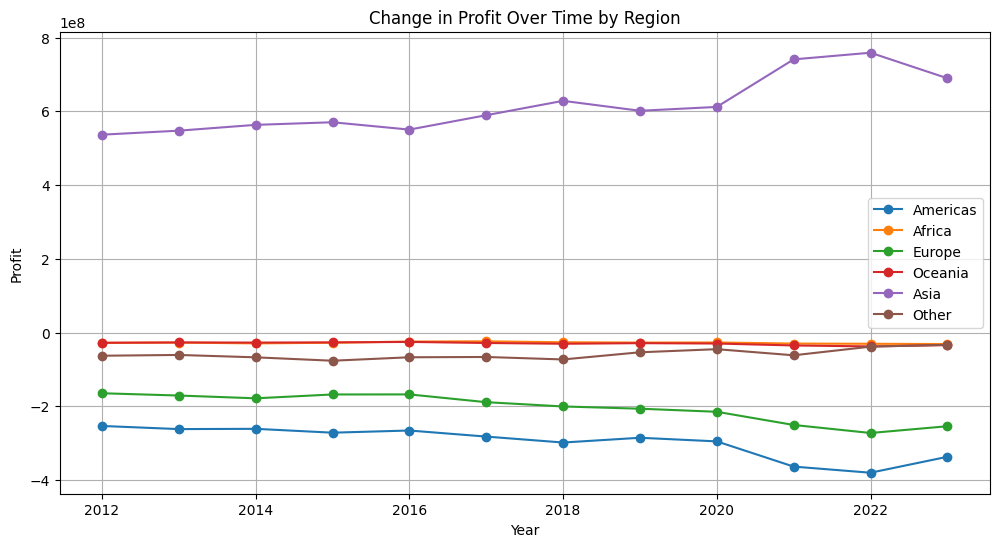

In [46]:
df_profit = df_global.groupby(['Year', 'Exporter_Region'], as_index=False)['Value'].sum()
df_imports = df_global.groupby(['Year', 'Importer_Region'], as_index=False)['Value'].sum()
df_imports.rename(columns={'Value': 'Import_Value', 'Importer_Region': 'Exporter_Region'}, inplace=True)

# Merge exports and imports to calculate profit per region per year
df_profit = df_profit.merge(df_imports, on=['Year', 'Exporter_Region'], how='left').fillna(0)
df_profit['Profit'] = df_profit['Value'] - df_profit['Import_Value']

plt.figure(figsize=(12, 6))

regions = ['Americas', 'Africa', 'Europe', 'Oceania', 'Asia', 'Global', 'Other']

for region in regions:
    df_region = df_profit[df_profit['Exporter_Region'] == region]
    
    if not df_region.empty:  # Ensure the dataframe is not empty before plotting
        plt.plot(df_region['Year'], df_region['Profit'], marker='o', label=region)

plt.xlabel('Year')
plt.ylabel('Profit')
plt.title('Change in Profit Over Time by Region')
plt.legend()
plt.grid()
plt.show()


In [21]:
import pandas as pd

data = {
    "Indicator": [
        "Waste generation (Mt) - Total e-waste",
        "Waste generation (Mt) - Embedded Waste Printed Circuit Board",
        "Environmental sound collection and recycling (Mt) - Total e-waste",
        "Environmental sound collection and recycling (Mt) - Printed Circuit Board Waste",
        "Not environmental sound managed e-waste (Mt) - Total e-waste",
        "Not environmental sound managed e-waste (Mt) - Embedded and Printed Circuit Board Waste",
        "Environmental sound collection and recycling rates - Total e-waste",
        "Environmental sound collection and recycling rates - Printed Circuit Board Waste",
        "Not environmental sound managed rates - Total e-waste",
        "Not environmental sound managed rates - Printed Circuit Board Waste",
        "Total Exports (kt)",
        "Controlled - E-waste reported as hazardous",
        "Controlled - Printed Circuit Board Waste",
        "Uncontrolled - Undocumented exports of mixed used EEE and e-waste",
        "Total Imports (kt)",
        "Controlled - E-waste reported as hazardous",
        "Controlled - Printed Circuit Board Waste",
        "Uncontrolled - Undocumented exports of mixed used EEE and e-waste",
        "Inhabitants (Million)"
    ],
    "Africa": [2.9, 0.1, 0.03, 0.01, 2.9, 0.1, "1%", "13%", "99%", "87%", 132, 12, 7, 113, 546, 19, 0, 527, 1152],
    "Americas": [13.1, 0.3, 1.2, 0.1, 11.9, 0.2, "9%", "44%", "91%", "56%", 547, 31, 128, 388, 393, 24, 65, 305, 984],
    "Asia": [24.9, 0.6, 2.9, 0.1, 22.0, 0.5, "12%", "17%", "88%", "83%", 2537, 1038, 36, 1463, 2889, 964, 111, 1814, 4445],
    "Europe": [12.0, 0.3, 5.1, 0.2, 6.9, 0.1, "42%", "61%", "58%", "39%", 1850, 375, 184, 1290, 1248, 457, 172, 619, 740],
    "Oceania": [0.7, 0.01, 0.06, 0.005, 0.6, 0.01, "9%", "31%", "91%", "69%", 21, 8, 4, 10, 0, 0, 0, 0, 42],
    "Global": [53.6, 1.2, 9.3, 0.4, 44.3, 0.8, "17%", "34%", "83%", "66%", 5086, 1464, 358, 3264, 5076, 1464, 348, 3264, 7363]
}

# Create DataFrame
df_pdf = pd.DataFrame(data)

df_pdf

Indicator Africa Americas  Asia  \
0               Waste generation (Mt) - Total e-waste    2.9     13.1  24.9   
1   Waste generation (Mt) - Embedded Waste Printed...    0.1      0.3   0.6   
2   Environmental sound collection and recycling (...   0.03      1.2   2.9   
3   Environmental sound collection and recycling (...   0.01      0.1   0.1   
4   Not environmental sound managed e-waste (Mt) -...    2.9     11.9  22.0   
5   Not environmental sound managed e-waste (Mt) -...    0.1      0.2   0.5   
6   Environmental sound collection and recycling r...     1%       9%   12%   
7   Environmental sound collection and recycling r...    13%      44%   17%   
8   Not environmental sound managed rates - Total ...    99%      91%   88%   
9   Not environmental sound managed rates - Printe...    87%      56%   83%   
10                                 Total Exports (kt)    132      547  2537   
11         Controlled - E-waste reported as hazardous     12       31  1038   
12           Controlled - Printed Circuit Board Waste      7      128    36   
13  Uncontrolled - Undocumented exports of mixed u...    113      388  1463   
14                                 Total Imports (kt)    546      393  2889   
15         Controlled - E-waste reported as hazardous     19       24   964   
16           Controlled - Printed Circuit Board Waste      0       65   111   
17  Uncontrolled - Undocumented exports of mixed u...    527      305  1814   
18                              Inhabitants (Million)   1152      984  4445   

   Europe Oceania Global  
0    12.0     0.7   53.6  
1     0.3    0.01    1.2  
2     5.1    0.06    9.3  
3     0.2   0.005    0.4  
4     6.9     0.6   44.3  
5     0.1    0.01    0.8  
6     42%      9%    17%  
7     61%     31%    34%  
8     58%     91%    83%  
9     39%     69%    66%  
10   1850      21   5086  
11    375       8   1464  
12    184       4    358  
13   1290      10   3264  
14   1248       0   5076  
15    457       0   1464  
16    172       0    348  
17    619       0   3264  
18    740      42   7363

In [22]:
pip install statsmodels


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
df_profit

Year Exporter_Region         Value  Import_Value        Profit
0   2012          Africa  3.437542e+06  3.149831e+07 -2.806077e+07
1   2012        Americas  1.635804e+08  4.169321e+08 -2.533517e+08
2   2012            Asia  8.702066e+08  3.335256e+08  5.366810e+08
3   2012          Europe  3.114920e+08  4.761382e+08 -1.646463e+08
4   2012         Oceania  2.790268e+06  3.051315e+07 -2.772288e+07
..   ...             ...           ...           ...           ...
67  2023        Americas  1.944589e+08  5.314596e+08 -3.370007e+08
68  2023            Asia  1.171816e+09  4.821404e+08  6.896757e+08
69  2023          Europe  3.853046e+08  6.394276e+08 -2.541229e+08
70  2023         Oceania  2.966169e+06  3.704638e+07 -3.408021e+07
71  2023           Other  8.132882e+07  1.145469e+08 -3.321805e+07

[72 rows x 5 columns]

/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version

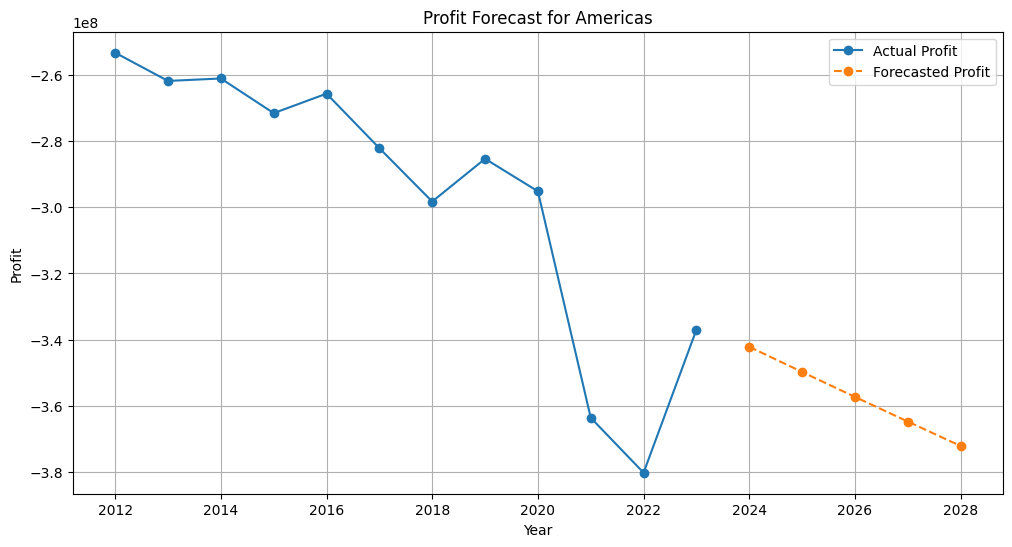

/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version

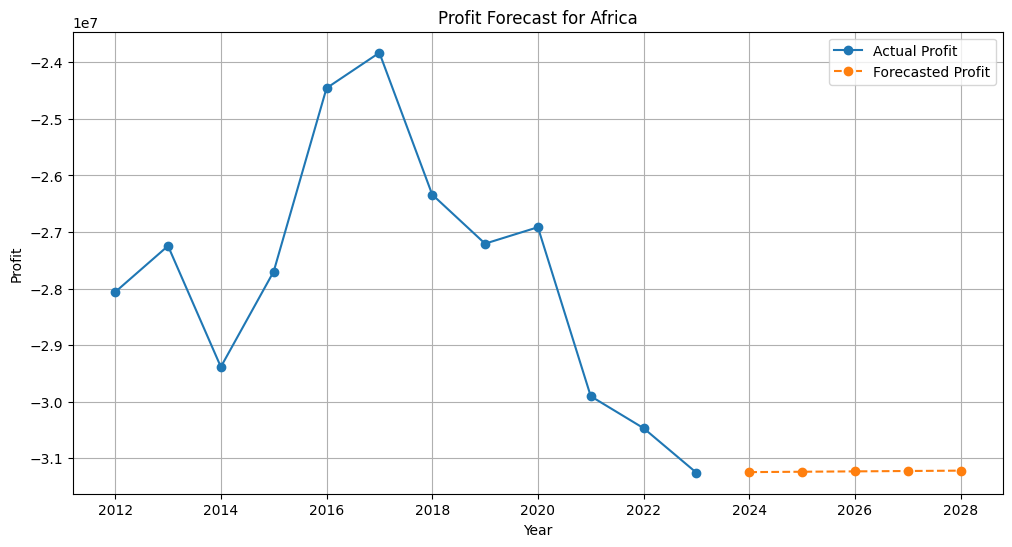

/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version

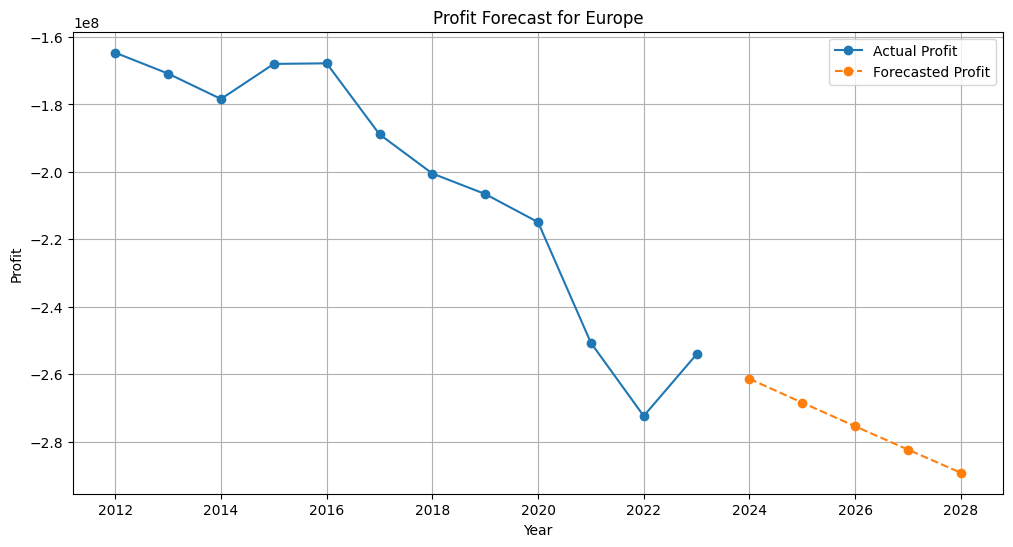

/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version

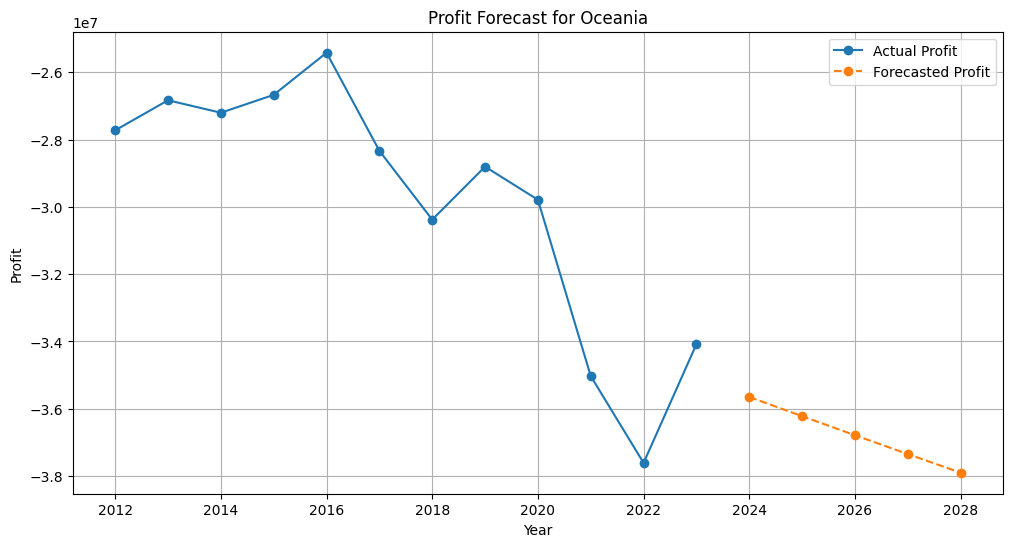

/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version

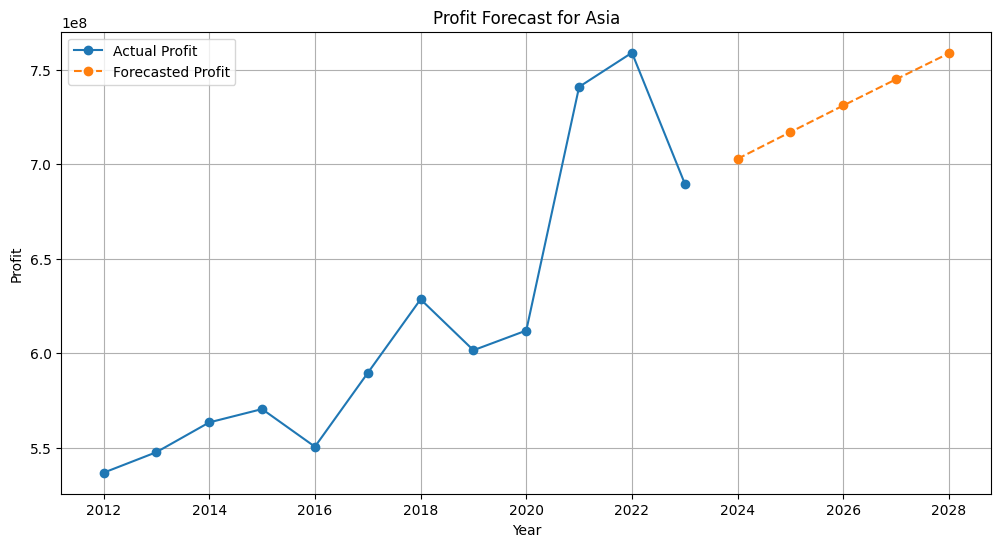

No data available for region: Global


/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pranavgunhal/Downloads/e-waste research /venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version

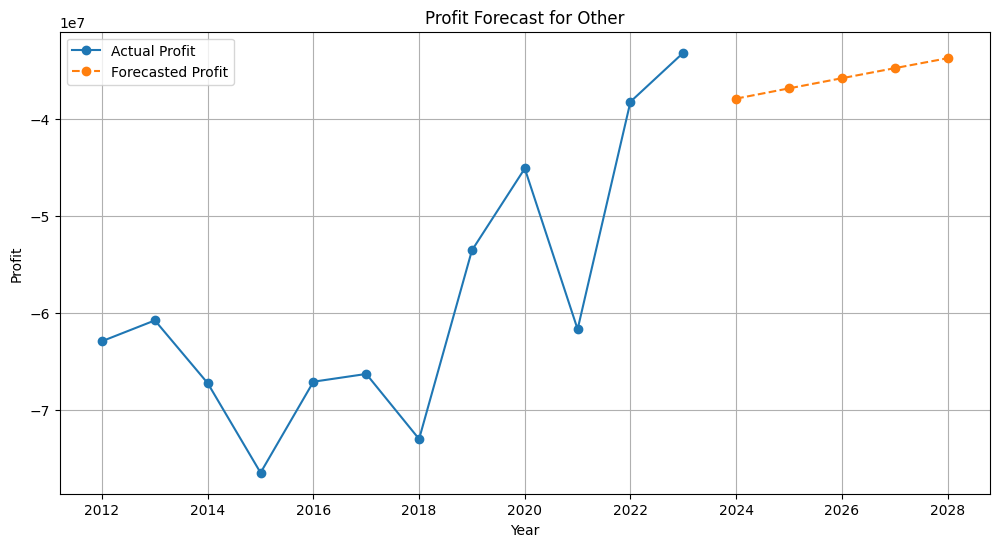

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
regions = ['Americas', 'Africa', 'Europe', 'Oceania', 'Asia', 'Global', 'Other']

for region in regions:
    df_region = df_profit[df_profit['Exporter_Region'] == region]

    if df_region.empty:
        print(f"No data available for region: {region}")
    else:
        # Fit Exponential Smoothing Model
        model = ExponentialSmoothing(df_region['Profit'], trend='add', seasonal=None, damped_trend=True)
        model_fit = model.fit()
    
        # Forecast next 5 years
        forecast_years = 5
        future_years = list(range(df_region['Year'].max() + 1, df_region['Year'].max() + 1 + forecast_years))
        forecast = model_fit.forecast(steps=forecast_years)
    
        # Plot actual vs forecasted profit
        plt.figure(figsize=(12, 6))
        plt.plot(df_region['Year'], df_region['Profit'], marker='o', label='Actual Profit')
        plt.plot(future_years, forecast, marker='o', linestyle='dashed', label='Forecasted Profit')
        plt.xlabel('Year')
        plt.ylabel('Profit')
        plt.title(f'Profit Forecast for {region}')
        plt.legend()
        plt.grid()
        plt.show()

In [25]:
# === SAVE ALL RELEVANT DATAFRAMES ===

# Main trade data after merging and filtering
df.to_csv("output_df_full.csv", index=False)

# If you created filtered versions per pipeline, save them here:
for stage in ["Mining", "Refining", "Manufacturing", "Assembly"]:
    hs_codes = stage_hscode_map.get(stage, [])
    filtered_stage_df = df[df["Product"].isin(hs_codes)]
    filtered_stage_df.to_csv(f"output_df_{stage.lower()}.csv", index=False)

# Save the mining HS metadata too
mining_df.to_csv("output_mining_metadata.csv", index=False)


NameError: name 'stage_hscode_map' is not defined